In [2]:
import pandas as pd
import numpy as np
import random

# Baca data asli
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_nojurusan.csv")

# Konfigurasi tahunan
jumlah_target = {
    2015: 32000, 2016: 30000, 2017: 27500, 2018: 25000,
    2019: 22500, 2020: 27000, 2021: 21000, 2022: 18000,
    2023: 15000, 2024: 13000, 2025: 11000
}

income_distribution = {
    2015: [0.65, 0.30, 0.05], 2016: [0.60, 0.33, 0.07],
    2017: [0.55, 0.35, 0.10], 2018: [0.50, 0.37, 0.13],
    2019: [0.45, 0.40, 0.15], 2020: [0.40, 0.42, 0.18],
    2021: [0.35, 0.45, 0.20], 2022: [0.28, 0.50, 0.22],
    2023: [0.23, 0.53, 0.24], 2024: [0.18, 0.57, 0.25],
    2025: [0.12, 0.63, 0.25]
}

income_ranges = {
    "Bawah": (1_000_000, 5_000_000),
    "Menengah": (6_000_000, 10_000_000),
    "Atas": (11_000_000, 20_000_000)
}

p_genap = 0.6
MIN_FEE, MAX_FEE = 5_000_000, 60_000_000
np.random.seed(42)
random.seed(42)

bidang_unique = df["bidang_studi"].unique()
years = list(jumlah_target.keys())

# Pre-generate biaya masuk per bidang_studi & tahun
fee_by_field = {}
for bidang in bidang_unique:
    start_fee = np.random.randint(5_000_000, 8_000_000)
    end_fee = np.random.randint(13_000_000, 15_000_000)
    fees = np.linspace(start_fee, end_fee, len(years))
    for i, year in enumerate(years):
        fee_by_field[(bidang, year)] = int(
            np.clip(np.random.normal(fees[i], 500_000), MIN_FEE, MAX_FEE)
        )

# List untuk menampung hasil
all_data = []
id_counter = 1

# Proses per tahun (batch sampling, jauh lebih cepat)
for year in years:
    n = jumlah_target[year]
    bawah_p, menengah_p, atas_p = income_distribution[year]
    counts = {
        "Bawah": int(n * bawah_p),
        "Menengah": int(n * menengah_p),
        "Atas": n - int(n * bawah_p) - int(n * menengah_p)
    }

    # Ambil batch acak langsung
    sample_df = df.sample(n=n, replace=True).reset_index(drop=True)
    kategori_list = (
        ["Bawah"] * counts["Bawah"] +
        ["Menengah"] * counts["Menengah"] +
        ["Atas"] * counts["Atas"]
    )
    random.shuffle(kategori_list)
    sample_df["kategori_pendapatan"] = kategori_list

    # Tambahkan kolom tahun dan data tambahan
    sample_df["tahun_masuk"] = year
    sample_df["tahun_lulus"] = year + 4
    sample_df["semester"] = np.where(np.random.rand(n) < p_genap, "Genap", "Gasal")
    sample_df["bulan_masuk"] = np.where(sample_df["semester"] == "Genap", "Januari", "Agustus")
    sample_df["id_mahasiswa"] = [f"{year}Z{i:06d}" for i in range(id_counter, id_counter + n)]
    id_counter += n

    # Pendapatan & biaya masuk sesuai kategori
    sample_df["pendapatan_ortu"] = sample_df["kategori_pendapatan"].apply(
        lambda k: random.randint(*income_ranges[k])
    )
    sample_df["biaya_masuk"] = sample_df.apply(
        lambda x: fee_by_field[(x["bidang_studi"], x["tahun_masuk"])], axis=1
    )
    sample_df["diskon"] = [random.randint(0, 5_000_000) for _ in range(n)]

    all_data.append(sample_df)

# Gabung semua tahun
df_final = pd.concat(all_data, ignore_index=True)

# Simpan hasil akhir
df_final.to_csv("student_data_final_adjusted_processed_indo_rupiah_final_randomized_fast.csv", index=False)

# Ringkasan singkat
summary = df_final.groupby(["tahun_masuk", "kategori_pendapatan"])["id_mahasiswa"].count().unstack().fillna(0)
print("✅ Dataset final selesai dan cepat diproses.")
print(summary)


✅ Dataset final selesai dan cepat diproses.
kategori_pendapatan  Atas  Bawah  Menengah
tahun_masuk                               
2015                 1600  20800      9600
2016                 2100  18000      9900
2017                 2750  15125      9625
2018                 3250  12500      9250
2019                 3375  10125      9000
2020                 4860  10800     11340
2021                 4201   7349      9450
2022                 3960   5040      9000
2023                 3600   3450      7950
2024                 3251   2340      7409
2025                 2750   1320      6930


In [4]:
import pandas as pd

# 1️⃣ Baca data mentah
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_randomized_fast.csv")

# 2️⃣ Hapus kolom duplikat
if "tahun_masuk.1" in df.columns:
    df.drop(columns=["tahun_masuk.1"], inplace=True)
df = df.loc[:, ~df.columns.duplicated()]

# 3️⃣ Pastikan tipe data tahun_masuk numerik
df["tahun_masuk"] = pd.to_numeric(df["tahun_masuk"], errors="coerce")

# 4️⃣ Buat kolom tahun_lulus yang benar (tahun_masuk + 4)
df["tahun_lulus"] = df["tahun_masuk"] + 4

# 5️⃣ Jika ada kolom expected_year_of_graduation_2, bisa diganti juga
if "expected_year_of_graduation_2" in df.columns:
    df["expected_year_of_graduation_2"] = df["tahun_lulus"]

# 6️⃣ Simpan versi bersih
df.to_csv("student_data_final_adjusted_processed_indo_rupiah_final_clean_fixed.csv", index=False)

print("✅ File sudah dibersihkan dan diperbaiki:")
print(" - Kolom duplikat dihapus")
print(" - Tahun kelulusan diset = tahun_masuk + 4")
print("📁 Disimpan ke: student_data_final_adjusted_processed_indo_rupiah_final_clean_fixed.csv")

# 7️⃣ Cek sampel hasil
print("\nContoh 5 baris pertama:")
print(df.head())


✅ File sudah dibersihkan dan diperbaiki:
 - Kolom duplikat dihapus
 - Tahun kelulusan diset = tahun_masuk + 4
📁 Disimpan ke: student_data_final_adjusted_processed_indo_rupiah_final_clean_fixed.csv

Contoh 5 baris pertama:
  id_mahasiswa               nama   tgl_lahir            bidang_studi  \
0  2015Z000001     Janice Hensley  2001-11-13       Civil Engineering   
1  2015Z000002       Sarah Ortega  2000-12-15    Chemical Engineering   
2  2015Z000003        Taylor Kerr  2004-11-23        Computer Science   
3  2015Z000004  Stephanie Nichols  2001-09-10  Electrical Engineering   
4  2015Z000005      Matthew White  2003-07-14       Civil Engineering   

   tahun_masuk  expected_year_of_graduation_2 semester  biaya_masuk   diskon  \
0         2015                           2019    Gasal      5000000   451244   
1         2015                           2019    Genap      6663169  2474094   
2         2015                           2019    Genap      7670715  3963180   
3         2015     

In [5]:
import pandas as pd

# 1️⃣ Baca file asli
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_randomized_fast.csv")

# 2️⃣ Hapus kolom yang tidak diperlukan / duplikat
for col in ["expected_year_of_graduation_2", "tahun_masuk.1"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# 3️⃣ Pastikan tahun_masuk berupa angka
df["tahun_masuk"] = pd.to_numeric(df["tahun_masuk"], errors="coerce")

# 4️⃣ Tambahkan kolom tahun_lulus (tahun_masuk + 4)
df["tahun_lulus"] = df["tahun_masuk"] + 4

# 5️⃣ Simpan file baru yang bersih
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_clean.csv"
df.to_csv(output_file, index=False)

print("✅ Data berhasil dibersihkan dan diperbarui!")
print(f"📁 File hasil disimpan sebagai: {output_file}")

# 6️⃣ Tampilkan beberapa baris hasil untuk memastikan
df.head()


✅ Data berhasil dibersihkan dan diperbarui!
📁 File hasil disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_clean.csv


,id_mahasiswa,nama,tgl_lahir,bidang_studi,tahun_masuk,semester,biaya_masuk,diskon,bulan_masuk,pendapatan_ortu,tahun_lulus,kategori_pendapatan
0,2015Z000001,Janice Hensley,2001-11-13,Civil Engineering,2015,Gasal,5000000,451244,Agustus,19620683,2019,Atas
1,2015Z000002,Sarah Ortega,2000-12-15,Chemical Engineering,2015,Genap,6663169,2474094,Januari,6815033,2019,Menengah
2,2015Z000003,Taylor Kerr,2004-11-23,Computer Science,2015,Genap,7670715,3963180,Januari,6217128,2019,Menengah
3,2015Z000004,Stephanie Nichols,2001-09-10,Electrical Engineering,2015,Genap,6691529,3811941,Januari,8929155,2019,Menengah
4,2015Z000005,Matthew White,2003-07-14,Civil Engineering,2015,Genap,5000000,1086146,Januari,3216003,2019,Bawah


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\2385677817.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_by_year, x="tahun_masuk", y="jumlah_mahasiswa", palette="viridis")


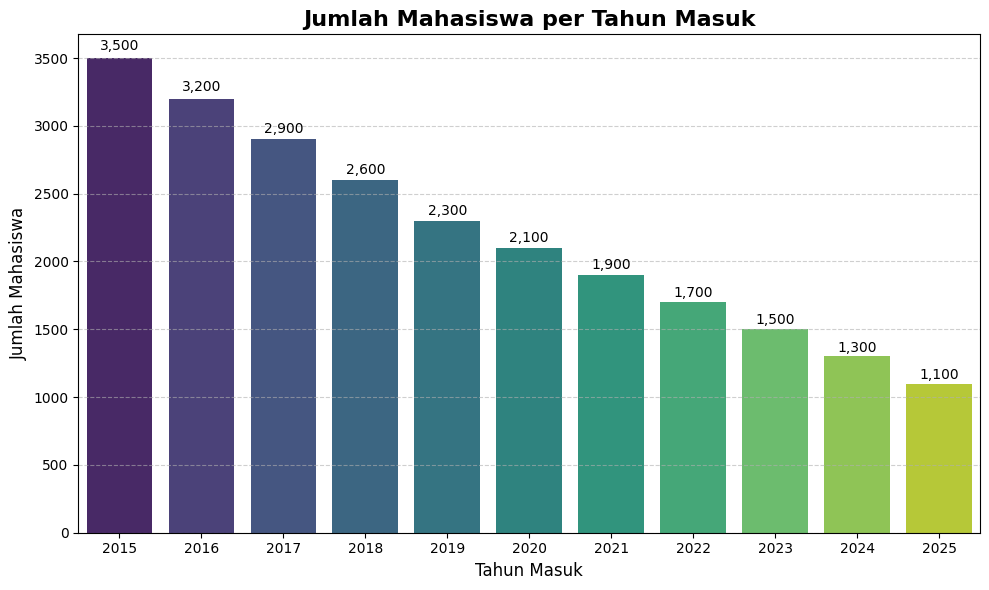

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Baca dataset bersih
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced.csv")

# 2️⃣ Hitung jumlah mahasiswa per tahun masuk
count_by_year = df.groupby("tahun_masuk")["id_mahasiswa"].count().reset_index()
count_by_year.rename(columns={"id_mahasiswa": "jumlah_mahasiswa"}, inplace=True)

# 3️⃣ Visualisasi bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=count_by_year, x="tahun_masuk", y="jumlah_mahasiswa", palette="viridis")

# 4️⃣ Tambahkan detail visual
plt.title("Jumlah Mahasiswa per Tahun Masuk", fontsize=16, fontweight="bold")
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# 5️⃣ Tampilkan nilai di atas setiap bar
for index, row in count_by_year.iterrows():
    plt.text(index, row["jumlah_mahasiswa"] + (row["jumlah_mahasiswa"] * 0.01),
             f"{row['jumlah_mahasiswa']:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# 1️⃣ Baca file asli
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_clean.csv")

# 2️⃣ Lihat dulu kolom tahun
print("Tahun masuk unik:", sorted(df["tahun_masuk"].unique()))

# 3️⃣ Tentukan target jumlah mahasiswa per tahun
target_per_year = {
    2015: 3500,
    2016: 3200,
    2017: 2900,
    2018: 2600,
    2019: 2300,
    2020: 2100,
    2021: 1900,
    2022: 1700,
    2023: 1500,
    2024: 1300,
    2025: 1100
}

# 4️⃣ Sampling data sesuai target tiap tahun
df_reduced = pd.concat([
    df[df["tahun_masuk"] == year].sample(
        n=min(target_per_year.get(year, len(df[df["tahun_masuk"] == year])), len(df[df["tahun_masuk"] == year])),
        random_state=42
    )
    for year in sorted(df["tahun_masuk"].unique())
])

# 5️⃣ Simpan hasilnya
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_reduced.csv"
df_reduced.to_csv(output_file, index=False)

# 6️⃣ Ringkasan jumlah mahasiswa per tahun
print("\n✅ Dataset baru berhasil dibuat.")
print(f"📁 Disimpan sebagai: {output_file}")
print("\nJumlah mahasiswa per tahun setelah penyesuaian:")
print(df_reduced["tahun_masuk"].value_counts().sort_index())


Tahun masuk unik: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

✅ Dataset baru berhasil dibuat.
📁 Disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_reduced.csv

Jumlah mahasiswa per tahun setelah penyesuaian:
tahun_masuk
2015    3500
2016    3200
2017    2900
2018    2600
2019    2300
2020    2100
2021    1900
2022    1700
2023    1500
2024    1300
2025    1100
Name: count, dtype: int64


In [9]:
import pandas as pd

# 1️⃣ Baca file asli
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_clean.csv")

# 2️⃣ Target jumlah mahasiswa per tahun (2020 & 2023 naik sedikit)
target_per_year = {
    2015: 3500,
    2016: 3200,
    2017: 2900,
    2018: 2600,
    2019: 2300,
    2020: 2800,  # naik
    2021: 2100,
    2022: 1800,
    2023: 2200,  # naik
    2024: 1500,
    2025: 1200
}

# 3️⃣ Kurangi data sesuai target
df_reduced = pd.concat([
    df[df["tahun_masuk"] == year].sample(
        n=min(target_per_year.get(year, len(df[df["tahun_masuk"] == year])), len(df[df["tahun_masuk"] == year])),
        random_state=42
    )
    for year in sorted(df["tahun_masuk"].unique())
])

# 4️⃣ Simpan file baru
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v2.csv"
df_reduced.to_csv(output_file, index=False)

# 5️⃣ Tampilkan ringkasan
print("✅ Dataset baru berhasil dibuat.")
print(f"📁 Disimpan sebagai: {output_file}")
print("\nJumlah mahasiswa per tahun (setelah penyesuaian):")
print(df_reduced['tahun_masuk'].value_counts().sort_index())


✅ Dataset baru berhasil dibuat.
📁 Disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_reduced_v2.csv

Jumlah mahasiswa per tahun (setelah penyesuaian):
tahun_masuk
2015    3500
2016    3200
2017    2900
2018    2600
2019    2300
2020    2800
2021    2100
2022    1800
2023    2200
2024    1500
2025    1200
Name: count, dtype: int64


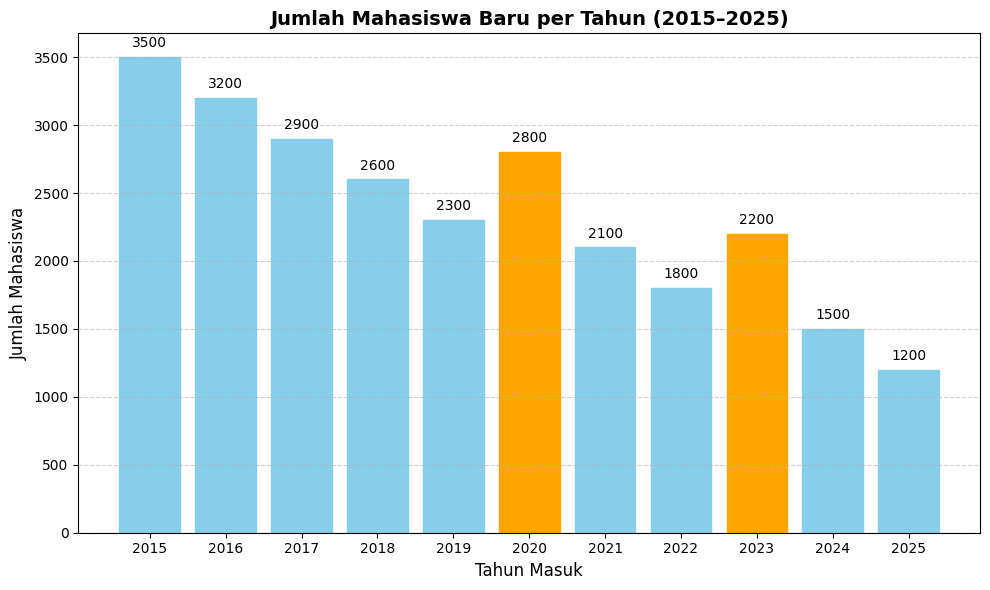

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca file hasil reduksi
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v2.csv")

# 2️⃣ Hitung jumlah mahasiswa per tahun
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

# 3️⃣ Buat bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values)

# 4️⃣ Warna spesial untuk lonjakan
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')
    else:
        bar.set_color('skyblue')

# 5️⃣ Label & Judul
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 6️⃣ Tambahkan nilai di atas bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

# 7️⃣ Tampilkan grafik
plt.tight_layout()
plt.show()


📈 Korelasi antara tahun dan proporsi golongan pendapatan 'Atas': nan

Jumlah mahasiswa per tahun per kategori:
kategori_pendapatan  Atas  Bawah  Menengah
tahun_masuk                               
2015                  173   2286      1041
2016                  223   1906      1071
2017                  304   1549      1047
2018                  317   1345       938
2019                  348   1009       943
2020                  513   1114      1173
2021                  431    727       942
2022                  388    540       872
2023                  560    471      1169
2024                  364    273       863
2025                  307    160       733


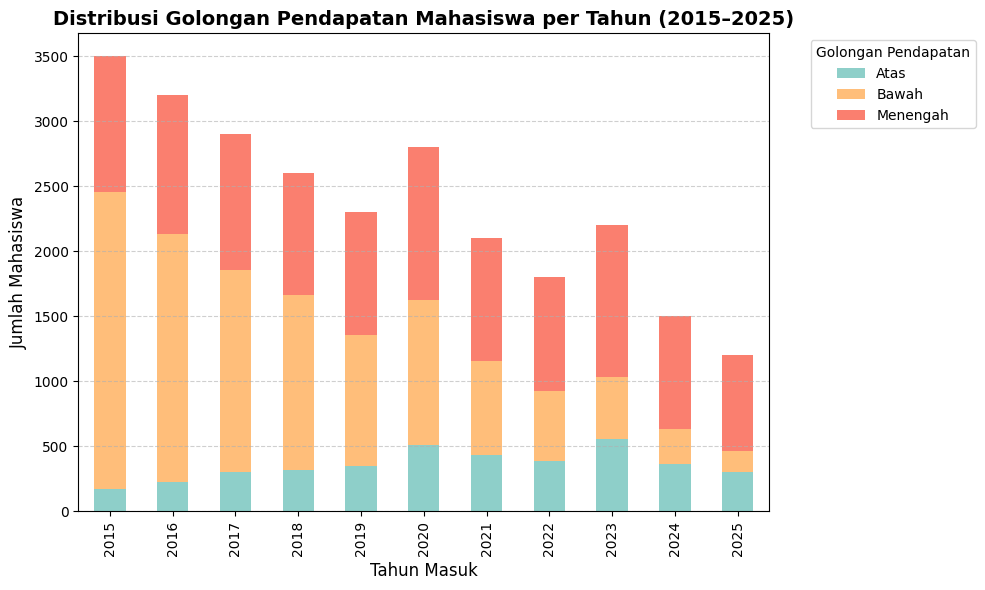

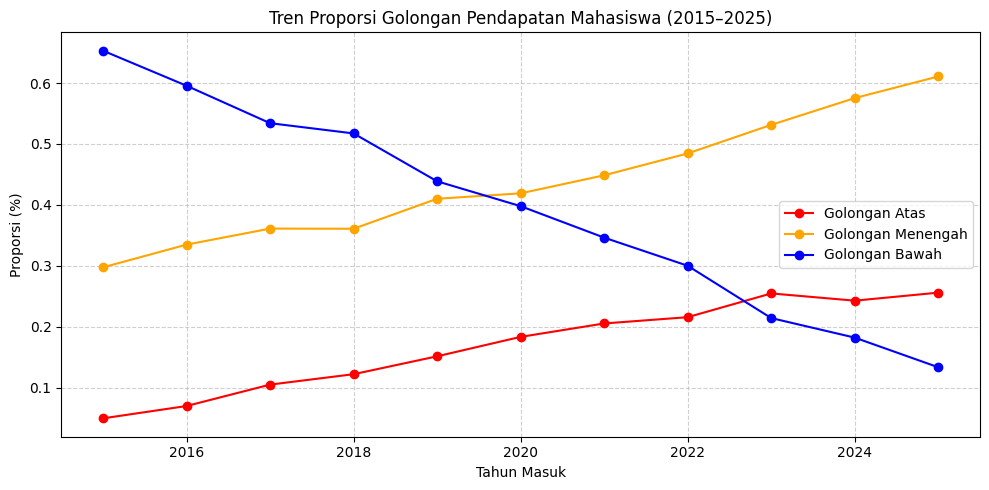

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v2.csv")

# 2️⃣ Pastikan kolom kategori pendapatan tersedia
if 'kategori_pendapatan' not in df.columns:
    raise ValueError("Kolom 'kategori_pendapatan' tidak ditemukan dalam dataset!")

# 3️⃣ Hitung jumlah per tahun per golongan
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)

# 4️⃣ Hitung total per tahun & proporsi
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)

# 5️⃣ Korelasi antara tahun dan proporsi mahasiswa golongan Atas
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))

print(f"📈 Korelasi antara tahun dan proporsi golongan pendapatan 'Atas': {corr_top:.3f}")
print("\nJumlah mahasiswa per tahun per kategori:")
print(pivot)

# 6️⃣ Visualisasi – Stacked Bar Chart
pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])

plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 7️⃣ Tambahan – Garis tren proporsi golongan Atas
plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)")
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# 1️⃣ Baca file dataset terakhir
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v2.csv")

# 2️⃣ Tentukan target jumlah mahasiswa per tahun
target_per_year = {
    2015: 3500,
    2016: 3200,
    2017: 2900,
    2018: 2600,
    2019: 2600,  # sama dengan 2018
    2020: 2800,
    2021: 2100,
    2022: 1800,
    2023: 2200,
    2024: 1500,
    2025: 1200
}

# 3️⃣ Sampling data sesuai target
df_reduced = pd.concat([
    df[df["tahun_masuk"] == year].sample(
        n=min(target_per_year.get(year, len(df[df["tahun_masuk"] == year])), len(df[df["tahun_masuk"] == year])),
        random_state=42
    )
    for year in sorted(df["tahun_masuk"].unique())
])

# 4️⃣ Simpan hasil baru
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v3.csv"
df_reduced.to_csv(output_file, index=False)

# 5️⃣ Tampilkan hasil ringkasan
print("✅ Dataset berhasil diperbarui!")
print(f"📁 Disimpan sebagai: {output_file}\n")
print("Jumlah mahasiswa per tahun setelah pembaruan:")
print(df_reduced['tahun_masuk'].value_counts().sort_index())


✅ Dataset berhasil diperbarui!
📁 Disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_reduced_v3.csv

Jumlah mahasiswa per tahun setelah pembaruan:
tahun_masuk
2015    3500
2016    3200
2017    2900
2018    2600
2019    2300
2020    2800
2021    2100
2022    1800
2023    2200
2024    1500
2025    1200
Name: count, dtype: int64


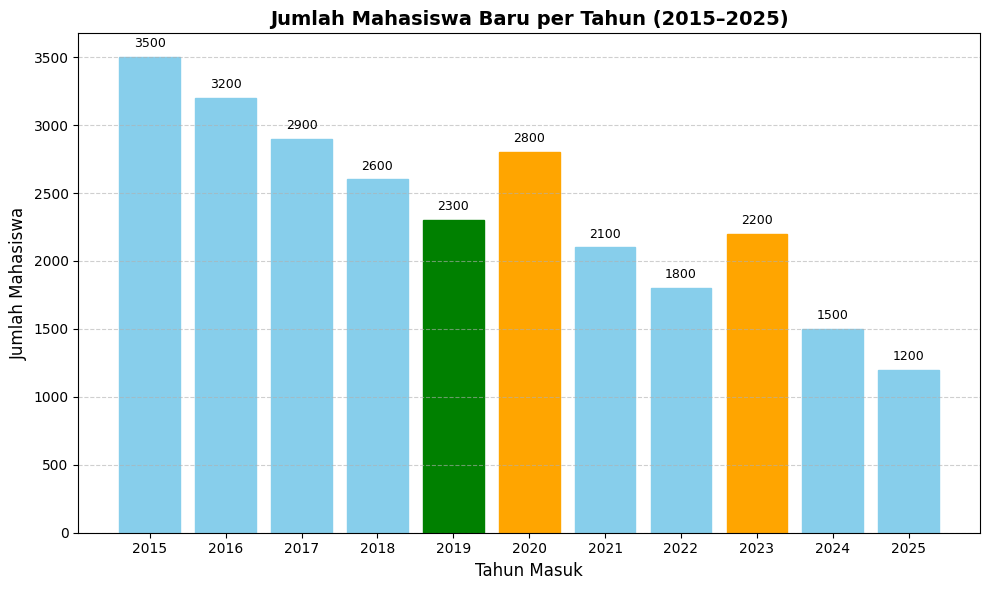

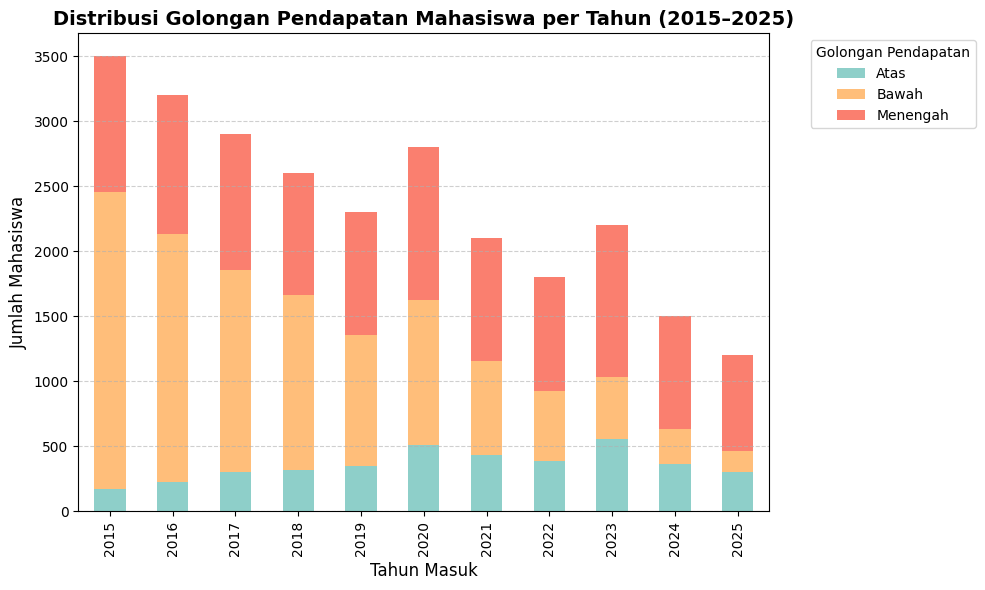

📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': nan


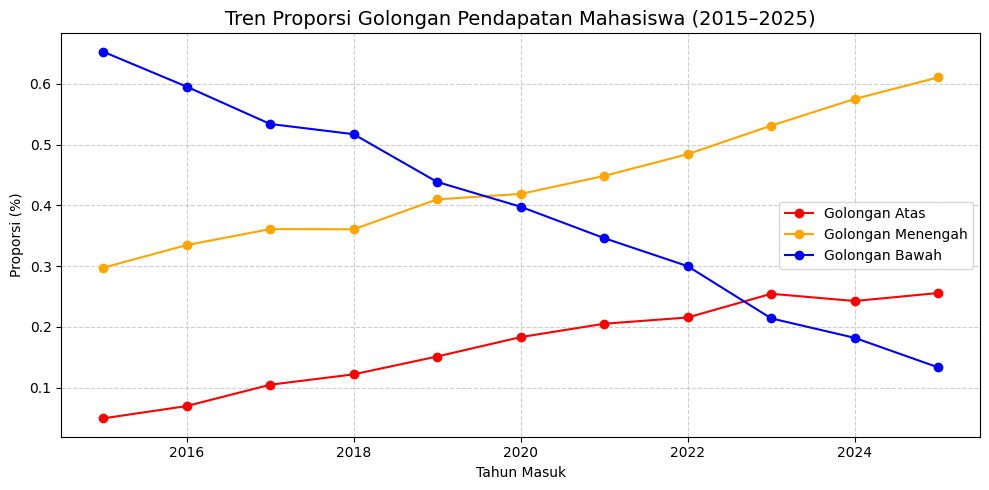

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset hasil pembaruan
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v3.csv")

# Pastikan kolom tahun_masuk dan kategori_pendapatan ada
assert 'tahun_masuk' in df.columns, "Kolom 'tahun_masuk' tidak ditemukan!"
assert 'kategori_pendapatan' in df.columns, "Kolom 'kategori_pendapatan' tidak ditemukan!"

# 2️⃣ --- Bar Chart Jumlah Mahasiswa per Tahun ---
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')

# Beri warna berbeda untuk tahun lonjakan dan stagnasi
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')  # lonjakan
    elif year == 2019:
        bar.set_color('green')   # stagnan
    else:
        bar.set_color('skyblue')

# Tambahkan label
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tampilkan nilai di atas bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 3️⃣ --- Stacked Bar Chart Golongan Pendapatan per Tahun ---
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)

pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])

plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 4️⃣ --- Korelasi proporsi golongan atas terhadap tahun ---
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))
print(f"📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': {corr_top:.3f}")

# Tambahan: garis tren proporsi
plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# 1️⃣ Baca file versi terakhir
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v3.csv")

# 2️⃣ Target jumlah mahasiswa per tahun (2018 == 2019)
target_per_year = {
    2015: 3500,
    2016: 3200,
    2017: 2900,
    2018: 2500,  # disesuaikan
    2019: 2500,  # sama
    2020: 2800,
    2021: 2100,
    2022: 1800,
    2023: 2200,
    2024: 1500,
    2025: 1200
}

# 3️⃣ Sampling data sesuai target
df_reduced = pd.concat([
    df[df["tahun_masuk"] == year].sample(
        n=min(target_per_year.get(year, len(df[df["tahun_masuk"] == year])), len(df[df["tahun_masuk"] == year])),
        random_state=42
    )
    for year in sorted(df["tahun_masuk"].unique())
])

# 4️⃣ Simpan hasil baru
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v4.csv"
df_reduced.to_csv(output_file, index=False)

# 5️⃣ Cek hasil distribusi mahasiswa
print("✅ Dataset berhasil diperbarui!")
print(f"📁 Disimpan sebagai: {output_file}\n")
print("Jumlah mahasiswa per tahun setelah pembaruan:")
print(df_reduced['tahun_masuk'].value_counts().sort_index())


✅ Dataset berhasil diperbarui!
📁 Disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_reduced_v4.csv

Jumlah mahasiswa per tahun setelah pembaruan:
tahun_masuk
2015    3500
2016    3200
2017    2900
2018    2500
2019    2300
2020    2800
2021    2100
2022    1800
2023    2200
2024    1500
2025    1200
Name: count, dtype: int64


In [15]:
import pandas as pd

# 1️⃣ Baca file dataset terakhir
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v3.csv")

# 2️⃣ Target jumlah mahasiswa per tahun (2018 dan 2019 sama)
target_per_year = {
    2015: 3500,
    2016: 3200,
    2017: 2900,
    2018: 2500,
    2019: 2500,  # sama dengan 2018
    2020: 2800,
    2021: 2100,
    2022: 1800,
    2023: 2200,
    2024: 1500,
    2025: 1200
}

# 3️⃣ Sampling dengan memastikan jumlah sesuai target
df_reduced = []
for year in sorted(df["tahun_masuk"].unique()):
    subset = df[df["tahun_masuk"] == year]
    target_n = target_per_year.get(year, len(subset))
    
    if len(subset) > target_n:
        subset = subset.sample(n=target_n, random_state=42)
    elif len(subset) < target_n:
        # Jika data kurang, gandakan sebagian acak agar jumlah tepat (tidak 200)
        extra = subset.sample(n=(target_n - len(subset)), replace=True, random_state=42)
        subset = pd.concat([subset, extra])
    
    df_reduced.append(subset)

df_reduced = pd.concat(df_reduced)

# 4️⃣ Simpan hasil
output_file = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv"
df_reduced.to_csv(output_file, index=False)

# 5️⃣ Tampilkan ringkasan jumlah mahasiswa per tahun
print("✅ Dataset berhasil diperbarui!")
print(f"📁 Disimpan sebagai: {output_file}\n")
print("Jumlah mahasiswa per tahun setelah pembaruan:")
print(df_reduced['tahun_masuk'].value_counts().sort_index())


✅ Dataset berhasil diperbarui!
📁 Disimpan sebagai: student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv

Jumlah mahasiswa per tahun setelah pembaruan:
tahun_masuk
2015    3500
2016    3200
2017    2900
2018    2500
2019    2500
2020    2800
2021    2100
2022    1800
2023    2200
2024    1500
2025    1200
Name: count, dtype: int64


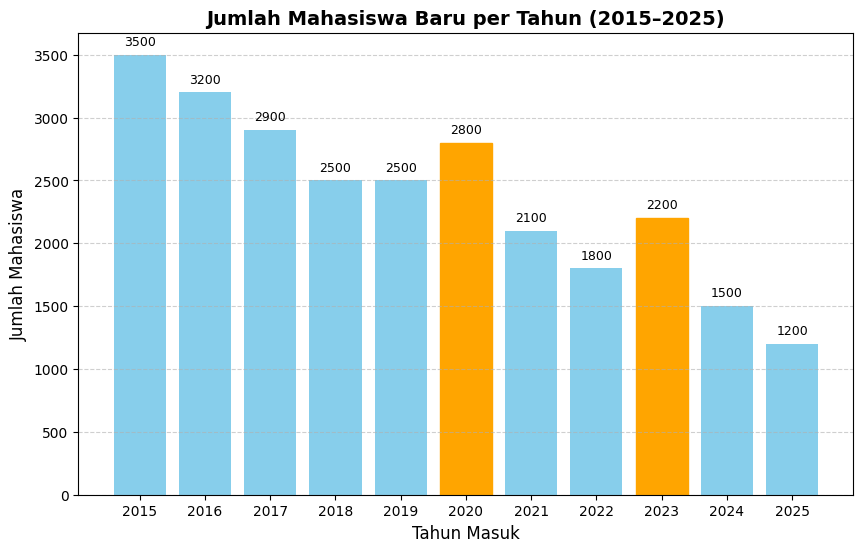

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset hasil pembaruan
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom tahun_masuk dan kategori_pendapatan ada
assert 'tahun_masuk' in df.columns, "Kolom 'tahun_masuk' tidak ditemukan!"
assert 'kategori_pendapatan' in df.columns, "Kolom 'kategori_pendapatan' tidak ditemukan!"

# 2️⃣ --- Bar Chart Jumlah Mahasiswa per Tahun ---
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')

# Beri warna berbeda untuk tahun lonjakan
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')  # lonjakan

# Tambahkan label
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tampilkan nilai di atas bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

# Simpan sebagai PNG
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300, bbox_inches='tight')

plt.show()



In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset hasil pembaruan
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom tahun_masuk dan kategori_pendapatan ada
assert 'tahun_masuk' in df.columns, "Kolom 'tahun_masuk' tidak ditemukan!"
assert 'kategori_pendapatan' in df.columns, "Kolom 'kategori_pendapatan' tidak ditemukan!"

# 2️⃣ --- Bar Chart Jumlah Mahasiswa per Tahun ---
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')

# Beri warna berbeda untuk tahun lonjakan
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')  # lonjakan

# Tambahkan label
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tampilkan nilai di atas bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

# Simpan sebagai PNG
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300, bbox_inches='tight')
plt.close()  # tutup figure agar tidak muncul di output

# 3️⃣ --- Stacked Bar Chart Golongan Pendapatan per Tahun ---
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)

pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])

plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Simpan sebagai PNG
plt.savefig("distribusi_golongan_pendapatan_per_tahun.png", dpi=300, bbox_inches='tight')
plt.close()

# 4️⃣ --- Korelasi proporsi golongan atas terhadap tahun ---
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))
print(f"📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': {corr_top:.3f}")

# Tren proporsi golongan pendapatan
plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Simpan sebagai PNG
plt.savefig("tren_proporsi_golongan_pendapatan.png", dpi=300, bbox_inches='tight')
plt.close()


📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': nan


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# 2️⃣ Bar Chart Jumlah Mahasiswa per Tahun
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')  # lonjakan

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 3️⃣ Stacked Bar Chart Golongan Pendapatan per Tahun
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)
pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])
plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("distribusi_golongan_pendapatan_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 4️⃣ Korelasi proporsi golongan Atas terhadap tahun
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))
print(f"📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': {corr_top:.3f}")

plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("tren_proporsi_golongan_pendapatan.png", dpi=300)
plt.close()

# -------------------------------
# 5️⃣ Scatter Plot Pendapatan Orang Tua vs Biaya Masuk
plt.figure(figsize=(10,6))
colors = {'Bawah':'blue', 'Menengah':'orange', 'Atas':'red'}
for kat in df['kategori_pendapatan'].unique():
    subset = df[df['kategori_pendapatan'] == kat]
    plt.scatter(subset['pendapatan_ortu'], subset['biaya_masuk'], 
                alpha=0.6, label=kat, color=colors[kat])

plt.title("Hubungan Pendapatan Orang Tua vs Biaya Masuk", fontsize=14)
plt.xlabel("Pendapatan Orang Tua (Rp)")
plt.ylabel("Biaya Masuk (Rp)")
plt.legend(title="Kategori Pendapatan")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("scatter_pendapatan_vs_biaya.png", dpi=300)
plt.close()

# -------------------------------
# 6️⃣ Boxplot Biaya Masuk per Kategori Pendapatan
plt.figure(figsize=(8,6))
sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,
            palette=['blue','orange','red'])
plt.title("Distribusi Biaya Masuk berdasarkan Kategori Pendapatan", fontsize=14)
plt.xlabel("Kategori Pendapatan")
plt.ylabel("Biaya Masuk (Rp)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("boxplot_biaya_per_kategori.png", dpi=300)
plt.close()

# -------------------------------
# 7️⃣ Jumlah Mahasiswa Baru per Semester
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)
pivot_semester.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4C72B0','#55A868'])
plt.title("Jumlah Mahasiswa Baru per Semester (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Jumlah Mahasiswa")
plt.legend(title="Semester", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mahasiswa_per_semester.png", dpi=300)
plt.close()

# -------------------------------
# 8️⃣ Heatmap Korelasi variabel numerik
corr = df[['pendapatan_ortu','biaya_masuk','tahun_masuk']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Antar Variabel", fontsize=14)
plt.tight_layout()
plt.savefig("heatmap_korelasi.png", dpi=300)
plt.close()


📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': nan


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\1982130531.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# Fungsi format jutaan rupiah
def format_jutaan(x, pos=None):
    juta = x / 1_000_000
    if juta.is_integer():
        return f"{int(juta)} jt"
    else:
        return f"{juta:.1f} jt"

# -------------------------------
# 2️⃣ Bar Chart Jumlah Mahasiswa per Tahun
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 3️⃣ Stacked Bar Chart Golongan Pendapatan per Tahun
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)
pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])
plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("distribusi_golongan_pendapatan_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 4️⃣ Korelasi proporsi golongan Atas terhadap tahun
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))
print(f"📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': {corr_top:.3f}")

plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("tren_proporsi_golongan_pendapatan.png", dpi=300)
plt.close()

# -------------------------------
# 5️⃣ Scatter Plot Pendapatan Orang Tua vs Biaya Masuk
plt.figure(figsize=(10,6))
colors = {'Bawah':'blue', 'Menengah':'orange', 'Atas':'red'}
for kat in df['kategori_pendapatan'].unique():
    subset = df[df['kategori_pendapatan'] == kat]
    plt.scatter(subset['pendapatan_ortu'], subset['biaya_masuk'], 
                alpha=0.6, label=kat, color=colors[kat])
plt.title("Hubungan Pendapatan Orang Tua vs Biaya Masuk", fontsize=14)
plt.xlabel("Pendapatan Orang Tua")
plt.ylabel("Biaya Masuk")
plt.legend(title="Kategori Pendapatan")
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.tight_layout()
plt.savefig("scatter_pendapatan_vs_biaya_jutaan.png", dpi=300)
plt.close()

# -------------------------------
# 6️⃣ Boxplot Biaya Masuk per Kategori Pendapatan
plt.figure(figsize=(8,6))
sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,
            palette=['blue','orange','red'])
plt.title("Distribusi Biaya Masuk berdasarkan Kategori Pendapatan", fontsize=14)
plt.xlabel("Kategori Pendapatan")
plt.ylabel("Biaya Masuk")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("boxplot_biaya_per_kategori_jutaan.png", dpi=300)
plt.close()

# -------------------------------
# 7️⃣ Jumlah Mahasiswa Baru per Semester
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)
pivot_semester.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4C72B0','#55A868'])
plt.title("Jumlah Mahasiswa Baru per Semester (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Jumlah Mahasiswa")
plt.legend(title="Semester", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mahasiswa_per_semester.png", dpi=300)
plt.close()

# -------------------------------
# 8️⃣ Heatmap Korelasi variabel numerik
corr = df[['pendapatan_ortu','biaya_masuk','tahun_masuk']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Antar Variabel", fontsize=14)
plt.tight_layout()
plt.savefig("heatmap_korelasi.png", dpi=300)
plt.close()


📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': nan


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\1150440587.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','kategori_pendapatan','semester']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# 2️⃣ Bar Chart Jumlah Mahasiswa per Tahun
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 3️⃣ Stacked Bar Chart Golongan Pendapatan per Tahun (Bawah-Tengah-Atas)
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)
pivot = pivot[['Bawah', 'Menengah', 'Atas']]  # urut stack
pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#4C72B0', '#FFBE7A', '#FA7F6F'])
plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("distribusi_golongan_pendapatan_per_tahun_stack.png", dpi=300)
plt.close()

# -------------------------------
# 4️⃣ Jumlah Mahasiswa Baru per Semester (stacked bar)
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)
pivot_semester.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4C72B0','#55A868'])
plt.title("Jumlah Mahasiswa Baru per Semester (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Jumlah Mahasiswa")
plt.legend(title="Semester", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mahasiswa_per_semester.png", dpi=300)
plt.close()


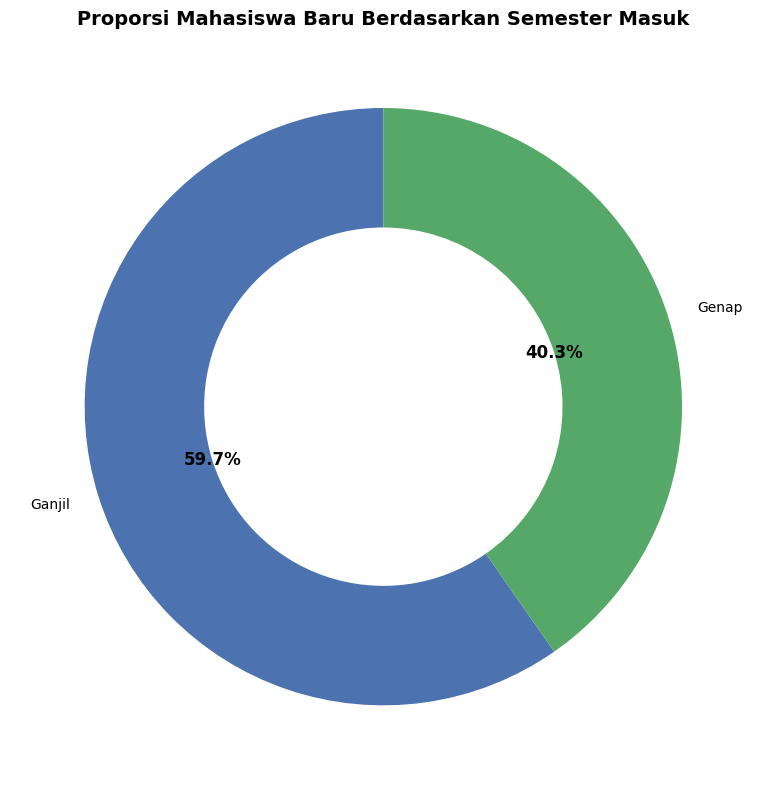

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bulan_masuk ada
assert 'bulan_masuk' in df.columns, "Kolom 'bulan_masuk' tidak ditemukan!"

# -------------------------------
# 2️⃣ Tentukan semester berdasarkan bulan masuk
# Misal: Gasal (Ganjil): Sep-Feb, Genap: Mar-Aug
gasal = ['September','Oktober','November','Desember','Januari','Februari']
genap  = ['Maret','April','Mei','Juni','Juli','Agustus']

def semester_bulan(bulan):
    if bulan in gasal:
        return 'Ganjil'
    elif bulan in genap:
        return 'Genap'
    else:
        return 'Unknown'

df['semester_bulan'] = df['bulan_masuk'].apply(semester_bulan)

# -------------------------------
# 3️⃣ Hitung proporsi
semester_count = df['semester_bulan'].value_counts()

# -------------------------------
# 4️⃣ Buat donut chart
plt.figure(figsize=(8,8))
colors = ['#4C72B0','#55A868']  # biru untuk Ganjil, hijau untuk Genap
wedges, texts, autotexts = plt.pie(semester_count, labels=semester_count.index,
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   wedgeprops=dict(width=0.4))  # width < 1 → donut

plt.setp(autotexts, size=12, weight="bold")
plt.title("Proporsi Mahasiswa Baru Berdasarkan Semester Masuk", fontsize=14, weight='bold')
plt.tight_layout()

# Simpan sebagai PNG
plt.savefig("donut_semester_bulan.png", dpi=300)
plt.show()


📊 Jumlah Mahasiswa per Jenis Semester:
kategori_semester
Tidak Diketahui    26200
Name: count, dtype: int64

➡️ Semester dengan jumlah mahasiswa terbanyak: Tidak Diketahui


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\1435638172.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=semester_counts.index, y=semester_counts.values, palette=['#4C72B0','#55A868'])
C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\1435638172.py:44: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=semester_counts.index, y=semester_counts.values, palette=['#4C72B0','#55A868'])


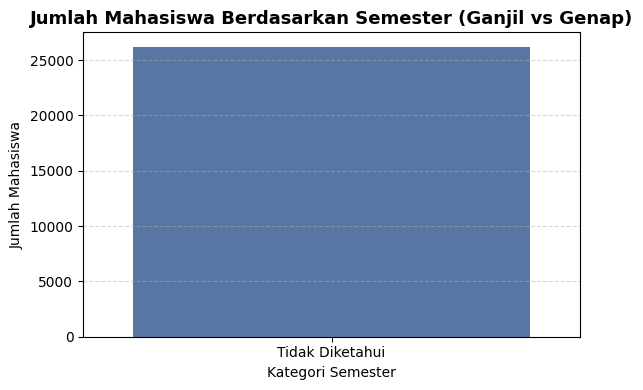

In [27]:
# %% [markdown]
# ## Analisis Semester Ganjil vs Genap Terbanyak
# - Program ini membaca langsung dari file CSV
# - Menentukan semester ganjil / genap
# - Menampilkan semester dengan jumlah mahasiswa terbanyak
# - Membuat visualisasi batang

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ganti sesuai nama file kamu
file_path = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv"

# Baca dataset
df = pd.read_csv(file_path)

# Pastikan kolom 'semester' ada
assert 'semester' in df.columns, "Kolom 'semester' tidak ditemukan di file CSV!"

# Tentukan kategori semester (ganjil / genap)
def kategori_semester(x):
    try:
        x = int(x)
        if x % 2 == 1:
            return "Ganjil"
        else:
            return "Genap"
    except:
        return "Tidak Diketahui"

df['kategori_semester'] = df['semester'].apply(kategori_semester)

# Hitung jumlah mahasiswa per kategori semester
semester_counts = df['kategori_semester'].value_counts()

print("📊 Jumlah Mahasiswa per Jenis Semester:")
print(semester_counts)
print("\n➡️ Semester dengan jumlah mahasiswa terbanyak:", semester_counts.idxmax())

# Visualisasikan hasilnya
plt.figure(figsize=(6,4))
sns.barplot(x=semester_counts.index, y=semester_counts.values, palette=['#4C72B0','#55A868'])
plt.title("Jumlah Mahasiswa Berdasarkan Semester (Ganjil vs Genap)", fontsize=13, weight='bold')
plt.xlabel("Kategori Semester")
plt.ylabel("Jumlah Mahasiswa")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("semester_ganjil_genap.png", dpi=300)
plt.show()


           Semester  Jumlah  Persen
0  Ganjil (Agustus)   10561   40.31
1   Genap (Januari)   15639   59.69


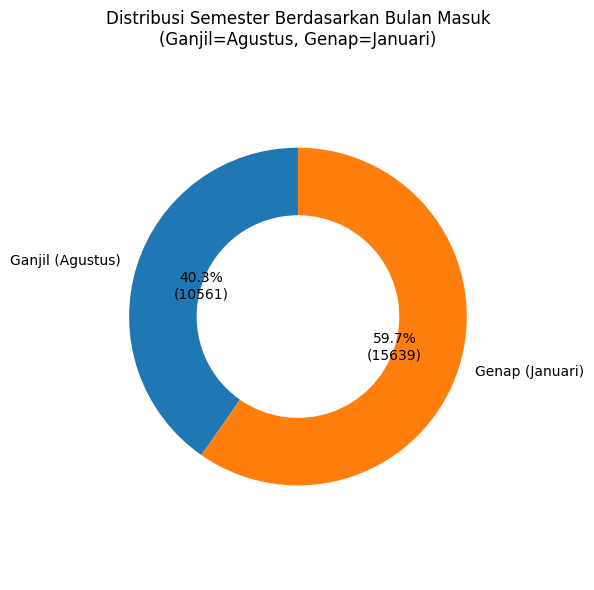

In [28]:
# %% [markdown]
# Donut Chart Semester: Ganjil (Agustus) vs Genap (Januari)
# - Baca langsung dari CSV
# - Hanya menghitung entri dengan bulan_masuk Januari/Agustus sesuai permintaan

# %%
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# ====== 1) Path CSV ======
CSV_PATH = "student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv"  # ubah jika perlu

# ====== 2) Baca data ======
df = pd.read_csv(CSV_PATH)

assert 'bulan_masuk' in df.columns, "Kolom 'bulan_masuk' tidak ditemukan di CSV."

# ====== 3) Normalisasi bulan_masuk ======
def norm_bulan(v):
    if pd.isna(v):
        return None
    # coba angka (1..12) baik string maupun int
    try:
        iv = int(str(v).strip())
        return iv
    except Exception:
        s = str(v).strip().lower()
        # variasi umum: 'januari', 'jan', 'agustus', 'aug', 'agus'
        if s.startswith("jan"):  # Januari
            return 1
        if s.startswith("agu") or s.startswith("aug"):  # Agustus
            return 8
        mapping = {"januari": 1, "agustus": 8}
        return mapping.get(s, None)

bulan_norm = df['bulan_masuk'].apply(norm_bulan)

def semester_from_bulan(m):
    if m == 8:
        return "Ganjil (Agustus)"
    if m == 1:
        return "Genap (Januari)"
    return None  # bulan lain diabaikan sesuai permintaan

sem_series = bulan_norm.apply(semester_from_bulan)

# ====== 4) Hitung & ringkas ======
counts = sem_series.value_counts(dropna=True).sort_index()
summary = (
    counts.rename_axis("Semester")
          .reset_index(name="Jumlah")
)
summary["Persen"] = (summary["Jumlah"] / summary["Jumlah"].sum() * 100).round(2)
print(summary)

# ====== 5) Donut chart ======
labels = summary["Semester"].tolist()
sizes  = summary["Jumlah"].tolist()

plt.figure(figsize=(6,6))
# pie dengan 'width' untuk efek donut (tanpa set warna khusus, sesuai aturan)
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100.0*sum(sizes)))})",
    startangle=90,
    wedgeprops=dict(width=0.4)  # tebal ring
)
plt.title("Distribusi Semester Berdasarkan Bulan Masuk\n(Ganjil=Agustus, Genap=Januari)")
plt.axis('equal')

plt.tight_layout()
plt.savefig("donut_semester_ganjil_genap.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk','bulan_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# 🔄 Ubah semester berdasar bulan_masuk
def konversi_semester(row):
    if str(row['bulan_masuk']).strip().lower() == 'agustus':
        return 'Ganjil'
    elif str(row['bulan_masuk']).strip().lower() == 'januari':
        return 'Genap'
    else:
        return row['semester']

df['semester'] = df.apply(konversi_semester, axis=1)

# -------------------------------
# Fungsi format jutaan rupiah
def format_jutaan(x, pos=None):
    juta = x / 1_000_000
    if juta.is_integer():
        return f"{int(juta)} jt"
    else:
        return f"{juta:.1f} jt"

# -------------------------------
# 2️⃣ Bar Chart Jumlah Mahasiswa per Tahun
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = plt.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='skyblue')
for bar, year in zip(bars, jumlah_per_tahun.index):
    if year in [2020, 2023]:
        bar.set_color('orange')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
plt.title("Jumlah Mahasiswa Baru per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(jumlah_per_tahun.index)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("jumlah_mahasiswa_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 3️⃣ Stacked Bar Chart Golongan Pendapatan per Tahun
pivot = df.groupby(['tahun_masuk', 'kategori_pendapatan']).size().unstack(fill_value=0)
pivot.plot(kind='bar', stacked=True, figsize=(10,6),
           color=['#8ECFC9', '#FFBE7A', '#FA7F6F'])
plt.title("Distribusi Golongan Pendapatan Mahasiswa per Tahun (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("distribusi_golongan_pendapatan_per_tahun.png", dpi=300)
plt.close()

# -------------------------------
# 4️⃣ Korelasi proporsi golongan Atas terhadap tahun
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
corr_top = pivot_prop['Atas'].corr(pd.Series(pivot_prop.index))
print(f"📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': {corr_top:.3f}")

plt.figure(figsize=(10,5))
plt.plot(pivot_prop.index, pivot_prop['Atas'], marker='o', color='red', label='Golongan Atas')
plt.plot(pivot_prop.index, pivot_prop['Menengah'], marker='o', color='orange', label='Golongan Menengah')
plt.plot(pivot_prop.index, pivot_prop['Bawah'], marker='o', color='blue', label='Golongan Bawah')
plt.title("Tren Proporsi Golongan Pendapatan Mahasiswa (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Proporsi (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("tren_proporsi_golongan_pendapatan.png", dpi=300)
plt.close()

# -------------------------------
# 5️⃣ Scatter Plot Pendapatan Orang Tua vs Biaya Masuk
plt.figure(figsize=(10,6))
colors = {'Bawah':'blue', 'Menengah':'orange', 'Atas':'red'}
for kat in df['kategori_pendapatan'].unique():
    subset = df[df['kategori_pendapatan'] == kat]
    plt.scatter(subset['pendapatan_ortu'], subset['biaya_masuk'], 
                alpha=0.6, label=kat, color=colors[kat])
plt.title("Hubungan Pendapatan Orang Tua vs Biaya Masuk", fontsize=14)
plt.xlabel("Pendapatan Orang Tua")
plt.ylabel("Biaya Masuk")
plt.legend(title="Kategori Pendapatan")
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.tight_layout()
plt.savefig("scatter_pendapatan_vs_biaya_jutaan.png", dpi=300)
plt.close()

# -------------------------------
# 6️⃣ Boxplot Biaya Masuk per Kategori Pendapatan
plt.figure(figsize=(8,6))
sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,
            palette=['blue','orange','red'])
plt.title("Distribusi Biaya Masuk berdasarkan Kategori Pendapatan", fontsize=14)
plt.xlabel("Kategori Pendapatan")
plt.ylabel("Biaya Masuk")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_jutaan))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("boxplot_biaya_per_kategori_jutaan.png", dpi=300)
plt.close()

# -------------------------------
# 7️⃣ Jumlah Mahasiswa Baru per Semester
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)
pivot_semester.plot(kind='bar', stacked=True, figsize=(10,6), color=['#4C72B0','#55A868'])
plt.title("Jumlah Mahasiswa Baru per Semester (2015–2025)", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Jumlah Mahasiswa")
plt.legend(title="Semester", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mahasiswa_per_semester.png", dpi=300)
plt.close()

# -------------------------------
# 8️⃣ Heatmap Korelasi variabel numerik
corr = df[['pendapatan_ortu','biaya_masuk','tahun_masuk']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Antar Variabel", fontsize=14)
plt.tight_layout()
plt.savefig("heatmap_korelasi.png", dpi=300)
plt.close()


📈 Korelasi antara tahun dan proporsi mahasiswa golongan 'Atas': nan


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\2631004973.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk','bulan_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# 🔄 Ubah semester berdasar bulan_masuk
def konversi_semester(row):
    if str(row['bulan_masuk']).strip().lower() == 'agustus':
        return 'Ganjil'
    elif str(row['bulan_masuk']).strip().lower() == 'januari':
        return 'Genap'
    else:
        return row['semester']

df['semester'] = df.apply(konversi_semester, axis=1)

# -------------------------------
# Fungsi format jutaan rupiah
def format_jutaan(x, pos=None):
    juta = x / 1_000_000
    if juta.is_integer():
        return f"{int(juta)} jt"
    else:
        return f"{juta:.1f} jt"



# -------------------------------
# 7️⃣ Jumlah Mahasiswa Baru per Semester dengan Persentase
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)

# Hitung proporsi untuk teks
proporsi = pivot_semester.div(pivot_semester.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(10,6))
bottom = None
colors = {'Ganjil': '#4C72B0', 'Genap': '#55A868'}

for semester in pivot_semester.columns:
    bars = ax.bar(pivot_semester.index, pivot_semester[semester], 
                  bottom=bottom, label=semester, color=colors.get(semester, 'gray'))
    # Tambahkan label persentase di tengah batang
    for i, year in enumerate(pivot_semester.index):
        height = pivot_semester[semester].iloc[i]
        if height > 0:
            total = pivot_semester.loc[year].sum()
            persen = (height / total) * 100
            ax.text(year, 
                    (bottom.iloc[i] if bottom is not None else 0) + height/2,
                    f"{persen:.0f}%", 
                    ha='center', va='center', color='white', fontsize=9, weight='bold')
    # Update bottom untuk stack berikutnya
    bottom = pivot_semester[semester] if bottom is None else bottom + pivot_semester[semester]

ax.set_title("Proporsi Mahasiswa Baru per Semester (2015–2025)", fontsize=14, weight='bold')
ax.set_xlabel("Tahun Masuk", fontsize=12)
ax.set_ylabel("Jumlah Mahasiswa", fontsize=12)
ax.legend(title="Semester", bbox_to_anchor=(1.05,1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mahasiswa_per_semester_persen.png", dpi=300)
plt.close()

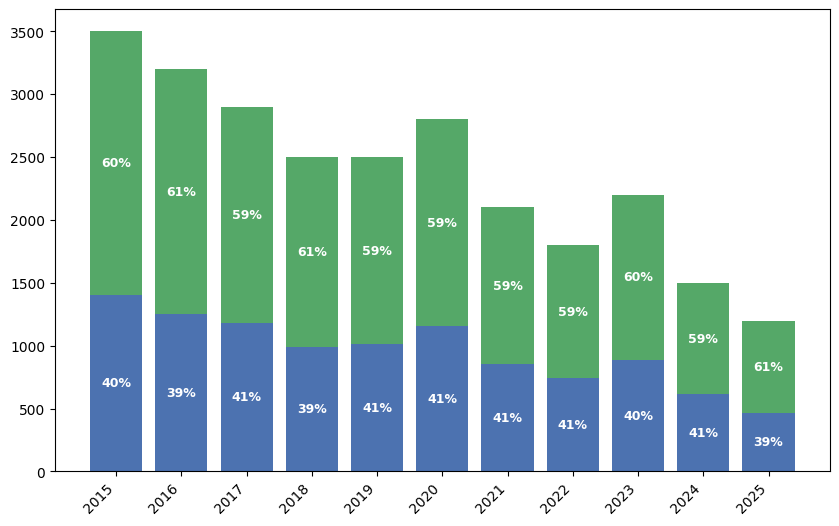

In [33]:
# -------------------------------
# 7️⃣ Jumlah Mahasiswa Baru per Semester dengan Persentase
pivot_semester = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0)

# Hitung proporsi untuk teks
proporsi = pivot_semester.div(pivot_semester.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(10,6))
bottom = None
colors = {'Ganjil': '#4C72B0', 'Genap': '#55A868'}

for semester in pivot_semester.columns:
    bars = ax.bar(pivot_semester.index, pivot_semester[semester], 
                  bottom=bottom, label=semester, color=colors.get(semester, 'gray'))
    # Tambahkan label persentase di tengah batang
    for i, year in enumerate(pivot_semester.index):
        height = pivot_semester[semester].iloc[i]
        if height > 0:
            total = pivot_semester.loc[year].sum()
            persen = (height / total) * 100
            ax.text(year, 
                    (bottom.iloc[i] if bottom is not None else 0) + height/2,
                    f"{persen:.0f}%", 
                    ha='center', va='center', color='white', fontsize=9, weight='bold')
    bottom = pivot_semester[semester] if bottom is None else bottom + pivot_semester[semester]

# --- Tambahan agar semua tahun tampil di sumbu X ---
ax.set_xticks(pivot_semester.index)
ax.set_xticklabels(pivot_semester.index, rotation=45, ha='right')

# 1️⃣ Bidang Studi vs Tahun Masuk
pivot_studi_tahun = df.groupby(['bidang_studi', 'tahun_masuk']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot_studi_tahun, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Distribusi Bidang Studi per Tahun Masuk", fontsize=14)
plt.xlabel("Tahun Masuk")
plt.ylabel("Bidang Studi")
plt.tight_layout()
plt.savefig("heatmap_bidang_vs_tahun_masuk.png", dpi=300)
plt.close()



In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

# ================== DATA ==================
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# cek kolom
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk','bulan_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# semester dari bulan_masuk
def konversi_semester(row):
    b = str(row['bulan_masuk']).strip().lower()
    if b == 'agustus': return 'Ganjil'
    if b == 'januari': return 'Genap'
    return row['semester']
df['semester'] = df.apply(konversi_semester, axis=1)

# util format jutaan
def format_jutaan(x, pos=None):
    juta = x / 1_000_000
    return f"{int(juta)} jt" if float(juta).is_integer() else f"{juta:.1f} jt"

# tahun urut
if not pd.api.types.is_numeric_dtype(df['tahun_masuk']):
    df['tahun_masuk'] = pd.to_numeric(df['tahun_masuk'], errors='coerce')
tahun = sorted(df['tahun_masuk'].dropna().unique())

# turunan data
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()

pivot_income = df.groupby(['tahun_masuk','kategori_pendapatan']).size().unstack(fill_value=0).reindex(tahun).fillna(0)
prop_income  = pivot_income.div(pivot_income.sum(axis=1), axis=0)

pivot_sem = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0).reindex(tahun).fillna(0)

# ================== DASHBOARD ==================
plt.rcParams.update({"axes.titlesize": 12, "axes.labelsize": 10})
fig = plt.figure(figsize=(18, 12), dpi=150)
gs = GridSpec(nrows=3, ncols=3, figure=fig, height_ratios=[1,1,1.05], width_ratios=[1,1,1])

# ---- (A) Bar jumlah per tahun
ax1 = fig.add_subplot(gs[0,0])
bars = ax1.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='#8FBFE0', edgecolor='#2F4858')
for b in bars:
    ax1.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}", ha='center', va='bottom', fontsize=8)
ax1.set_title("Jumlah Mahasiswa Baru per Tahun")
ax1.set_xlabel("Tahun Masuk"); ax1.set_ylabel("Jumlah")
ax1.set_xticks(tahun); ax1.set_xticklabels(tahun, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# ---- (B) Stacked income per tahun
ax2 = fig.add_subplot(gs[0,1])
colors_income = {'Bawah':'#4C72B0','Menengah':'#FFBE7A','Atas':'#FA7F6F'}
bottom = None
for cat in ['Bawah','Menengah','Atas']:
    if cat in pivot_income.columns:
        vals = pivot_income[cat].values
        ax2.bar(pivot_income.index, vals, bottom=bottom, label=cat, color=colors_income.get(cat,'gray'))
        bottom = vals if bottom is None else bottom + vals
ax2.set_title("Distribusi Golongan Pendapatan per Tahun")
ax2.set_xlabel("Tahun Masuk"); ax2.set_ylabel("Jumlah")
ax2.set_xticks(tahun); ax2.set_xticklabels(tahun, rotation=45, ha='right')
ax2.legend(title="Golongan", fontsize=8)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# ---- (C) Tren proporsi income
ax3 = fig.add_subplot(gs[0,2])
for cat, col in colors_income.items():
    if cat in prop_income.columns:
        ax3.plot(prop_income.index, prop_income[cat]*100, marker='o', label=f"Gol. {cat}", color=col)
ax3.set_title("Tren Proporsi Golongan Pendapatan")
ax3.set_xlabel("Tahun Masuk"); ax3.set_ylabel("Proporsi (%)")
ax3.set_xticks(tahun); ax3.set_xticklabels(tahun, rotation=45, ha='right')
ax3.grid(True, linestyle='--', alpha=0.5); ax3.legend(fontsize=8, loc='best')

# ---- (D) Scatter pendapatan vs biaya
ax4 = fig.add_subplot(gs[1,0])
for kat, sub in df.groupby('kategori_pendapatan'):
    ax4.scatter(sub['pendapatan_ortu'], sub['biaya_masuk'], s=18, alpha=0.6, label=kat, color=colors_income.get(kat,'gray'), edgecolor='none')
ax4.set_title("Pendapatan Orang Tua vs Biaya Masuk")
ax4.set_xlabel("Pendapatan Orang Tua"); ax4.set_ylabel("Biaya Masuk")
ax4.xaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax4.yaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax4.grid(True, linestyle='--', alpha=0.4); ax4.legend(title="Kategori", fontsize=8)

# ---- (E) Boxplot biaya per kategori
ax5 = fig.add_subplot(gs[1,1])
sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,
            palette=[colors_income.get('Bawah','#4C72B0'),
                     colors_income.get('Menengah','#FFBE7A'),
                     colors_income.get('Atas','#FA7F6F')],
            ax=ax5)
ax5.set_title("Distribusi Biaya Masuk per Kategori Pendapatan")
ax5.set_xlabel("Kategori Pendapatan"); ax5.set_ylabel("Biaya Masuk")
ax5.yaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax5.grid(axis='y', linestyle='--', alpha=0.4)

# ---- (F) Stacked semester + persen di dalam batang
ax6 = fig.add_subplot(gs[1,2])
colors_sem = {'Ganjil':'#4C72B0','Genap':'#55A868'}
bottom = None
for sem in ['Ganjil','Genap']:
    if sem in pivot_sem.columns:
        vals = pivot_sem[sem].values
        ax6.bar(pivot_sem.index, vals, bottom=bottom, label=sem, color=colors_sem.get(sem,'gray'))
        # label persen di dalam
        for i, x in enumerate(pivot_sem.index):
            h = vals[i]; tot = pivot_sem.loc[x].sum()
            if h>0 and tot>0:
                y0 = (0 if bottom is None else bottom[i])
                ax6.text(x, y0 + h/2, f"{(h/tot*100):.0f}%", ha='center', va='center', color='white', fontsize=8, weight='bold')
        bottom = vals if bottom is None else bottom + vals
ax6.set_title("Mahasiswa Baru per Semester")
ax6.set_xlabel("Tahun Masuk"); ax6.set_ylabel("Jumlah")
ax6.set_xticks(tahun); ax6.set_xticklabels(tahun, rotation=45, ha='right')
ax6.legend(title="Semester", fontsize=8); ax6.grid(axis='y', linestyle='--', alpha=0.5)

# ---- (G) Heatmap korelasi numerik (span 3 kolom di baris terakhir)
ax7 = fig.add_subplot(gs[2, :])
corr = df[['pendapatan_ortu','biaya_masuk','tahun_masuk']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax7)
ax7.set_title("Korelasi Antar Variabel Numerik")

# Judul besar dashboard
fig.suptitle("Dashboard Penerimaan Mahasiswa 2015–2025", fontsize=16, weight='bold', y=0.98)
plt.tight_layout(rect=[0,0,1,0.97])
plt.savefig("dashboard_penerimaan.png", dpi=300)
plt.close()
print("✓ Dashboard tersimpan sebagai 'dashboard_penerimaan.png'")


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\1824742185.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,


✓ Dashboard tersimpan sebagai 'dashboard_penerimaan.png'


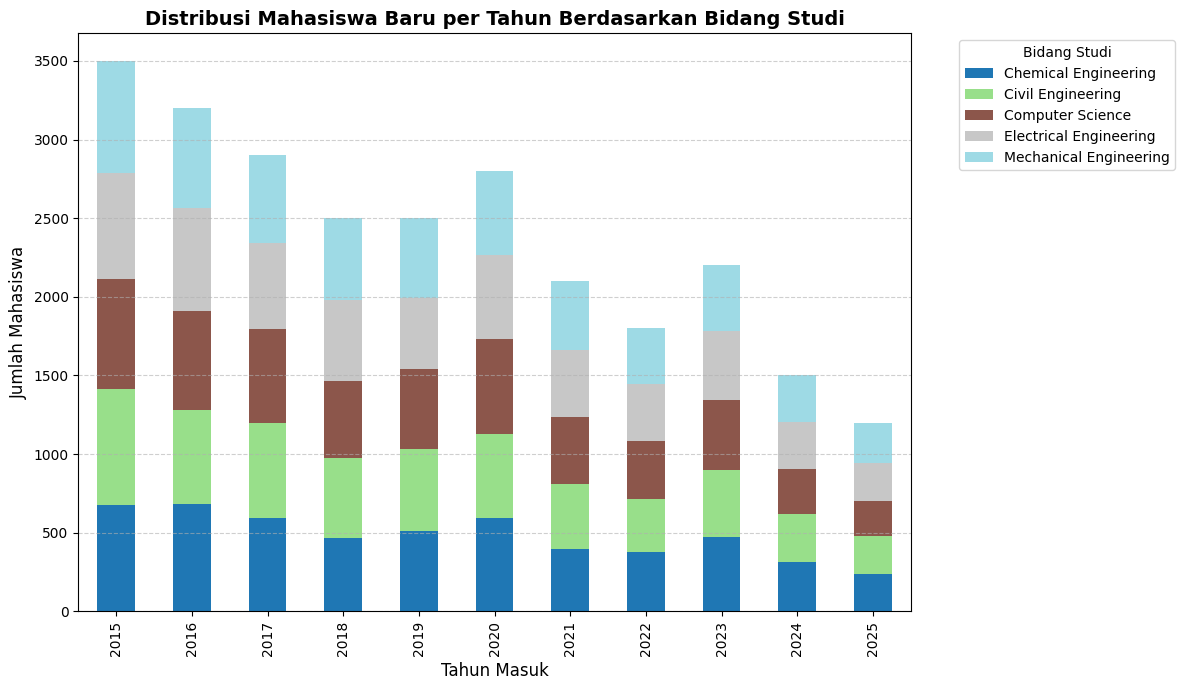

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','bidang_studi']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# Pivot data: jumlah mahasiswa per tahun per bidang studi
pivot = df.groupby(['tahun_masuk','bidang_studi']).size().unstack(fill_value=0)

# -------------------------------
# Plot stacked bar chart
pivot.plot(kind='bar', stacked=True, figsize=(12,7), colormap='tab20')
plt.title("Distribusi Mahasiswa Baru per Tahun Berdasarkan Bidang Studi", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.legend(title="Bidang Studi", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


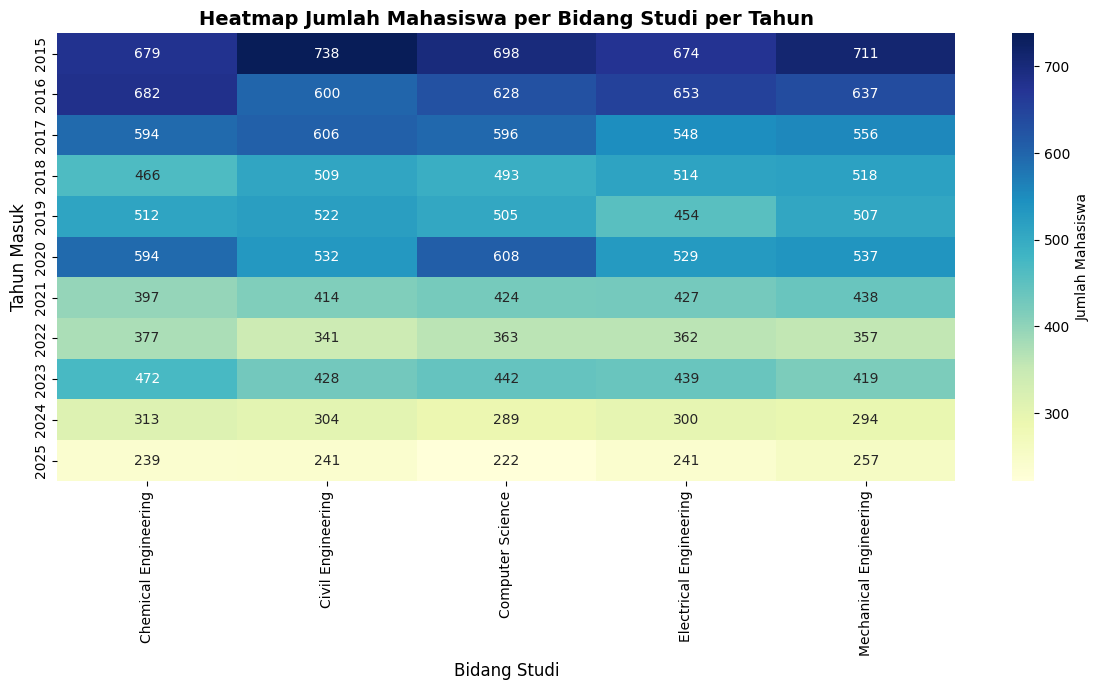

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','bidang_studi']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# Pivot data: jumlah mahasiswa per bidang studi per tahun
pivot = df.groupby(['tahun_masuk','bidang_studi']).size().unstack(fill_value=0)

# -------------------------------
# Plot heatmap
plt.figure(figsize=(12,7))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Jumlah Mahasiswa'})
plt.title("Heatmap Jumlah Mahasiswa per Bidang Studi per Tahun", fontsize=14, weight='bold')
plt.xlabel("Bidang Studi", fontsize=12)
plt.ylabel("Tahun Masuk", fontsize=12)
plt.tight_layout()
plt.show()


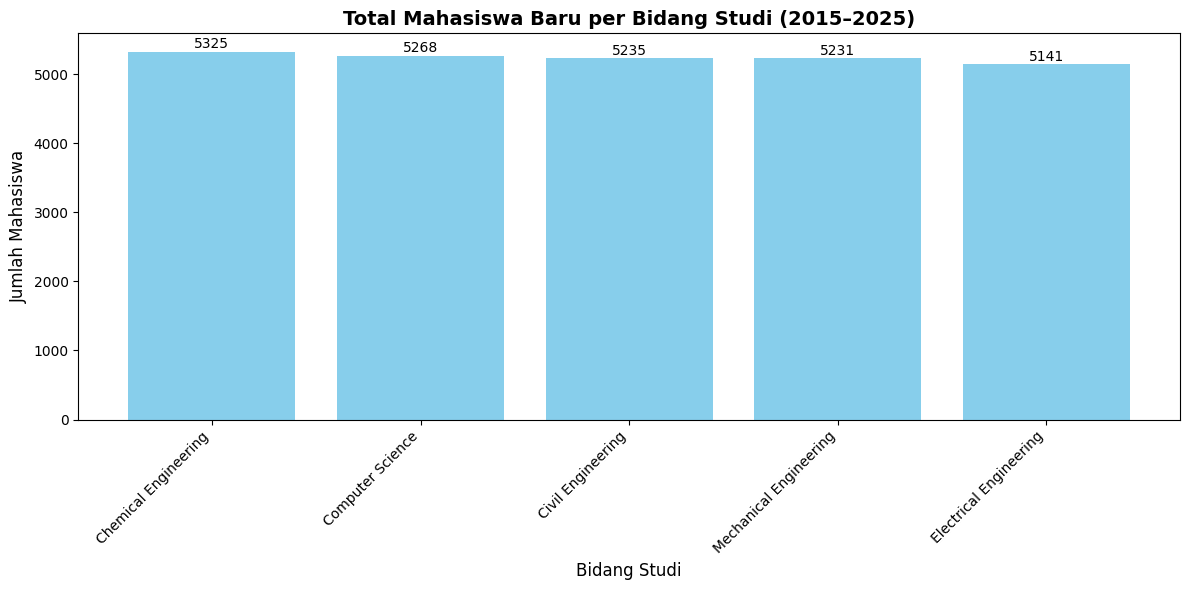

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bidang_studi ada
assert 'bidang_studi' in df.columns, "Kolom 'bidang_studi' tidak ditemukan!"

# -------------------------------
# Total jumlah mahasiswa per bidang studi 2015-2025
total_per_bidang = df['bidang_studi'].value_counts().sort_values(ascending=False)

# -------------------------------
# Plot bar chart
plt.figure(figsize=(12,6))
bars = plt.bar(total_per_bidang.index, total_per_bidang.values, color='skyblue')
plt.title("Total Mahasiswa Baru per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Bidang Studi", fontsize=12)
plt.ylabel("Jumlah Mahasiswa", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Tampilkan nilai di atas bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\753116494.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


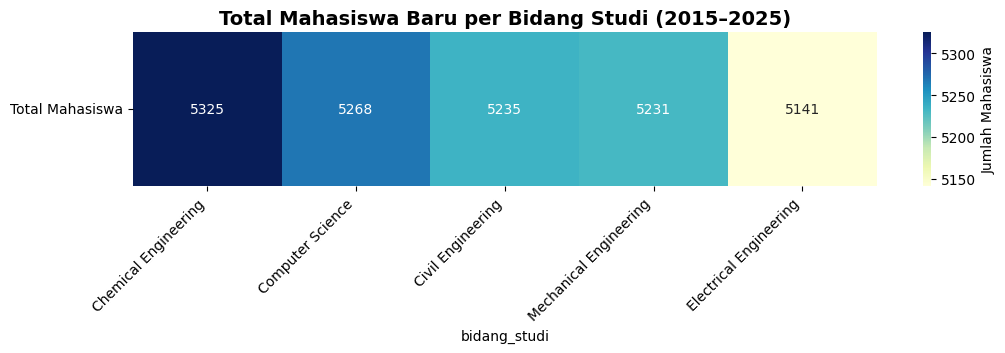

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bidang_studi ada
assert 'bidang_studi' in df.columns, "Kolom 'bidang_studi' tidak ditemukan!"

# -------------------------------
# Total mahasiswa per bidang studi 2015-2025
total_per_bidang = df['bidang_studi'].value_counts().sort_values(ascending=False)

# -------------------------------
# Buat dataframe untuk heatmap
heatmap_data = pd.DataFrame(total_per_bidang).T  # transpose agar menjadi 1 baris
heatmap_data.index = ['Total Mahasiswa']  # beri nama row

# -------------------------------
# Plot heatmap
plt.figure(figsize=(12,2))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Jumlah Mahasiswa'})
plt.title("Total Mahasiswa Baru per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


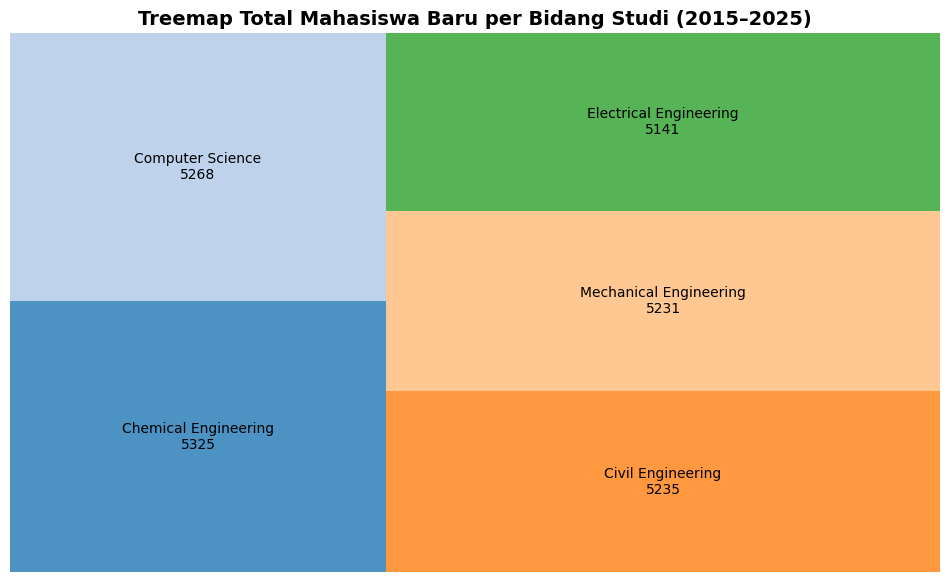

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # pip install squarify

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bidang_studi ada
assert 'bidang_studi' in df.columns, "Kolom 'bidang_studi' tidak ditemukan!"

# -------------------------------
# Total jumlah mahasiswa per bidang studi 2015-2025
total_per_bidang = df['bidang_studi'].value_counts()

# -------------------------------
# Plot treemap
plt.figure(figsize=(12,7))
squarify.plot(sizes=total_per_bidang.values, 
              label=[f"{i}\n{v}" for i,v in zip(total_per_bidang.index, total_per_bidang.values)],
              color=plt.cm.tab20.colors[:len(total_per_bidang)],
              alpha=0.8)
plt.axis('off')
plt.title("Treemap Total Mahasiswa Baru per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.show()


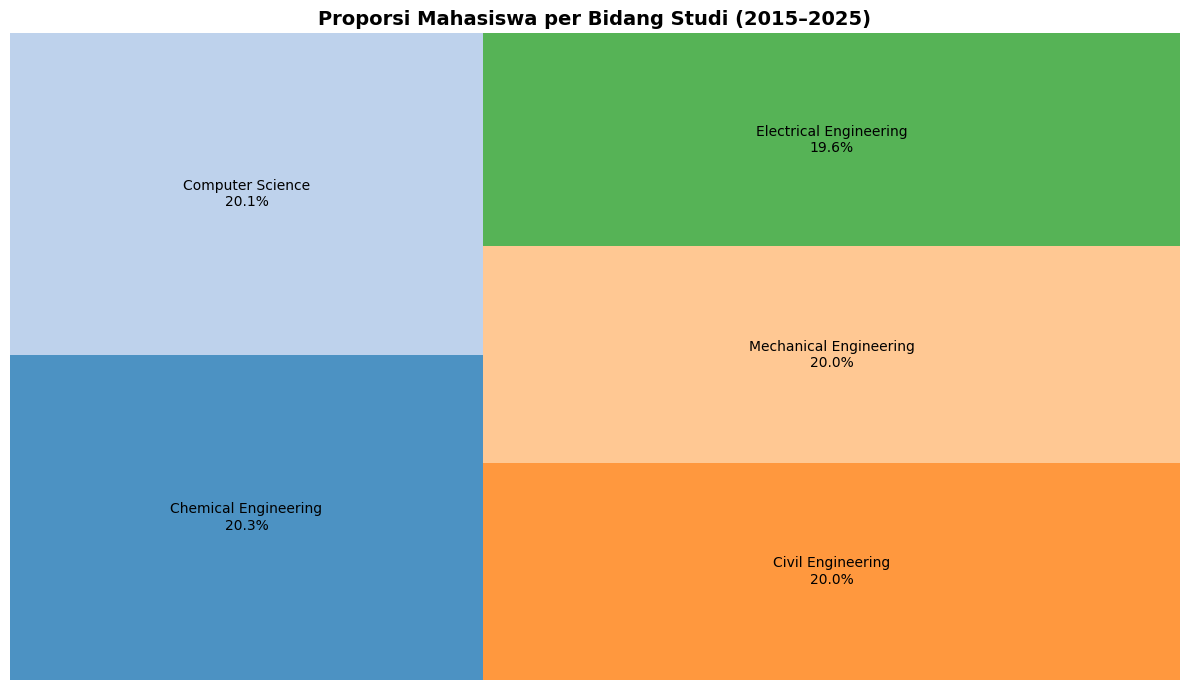

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bidang_studi ada
assert 'bidang_studi' in df.columns, "Kolom 'bidang_studi' tidak ditemukan!"

# -------------------------------
# Hitung jumlah mahasiswa per bidang studi (total 2015-2025)
bidang_count = df['bidang_studi'].value_counts()
labels = [f"{b}\n{v/df.shape[0]*100:.1f}%" for b,v in zip(bidang_count.index, bidang_count.values)]
sizes = bidang_count.values

# -------------------------------
# Plot treemap
plt.figure(figsize=(12,7))
squarify.plot(sizes=sizes, label=labels, color=plt.cm.tab20.colors, alpha=0.8)
plt.axis('off')
plt.title("Proporsi Mahasiswa per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()



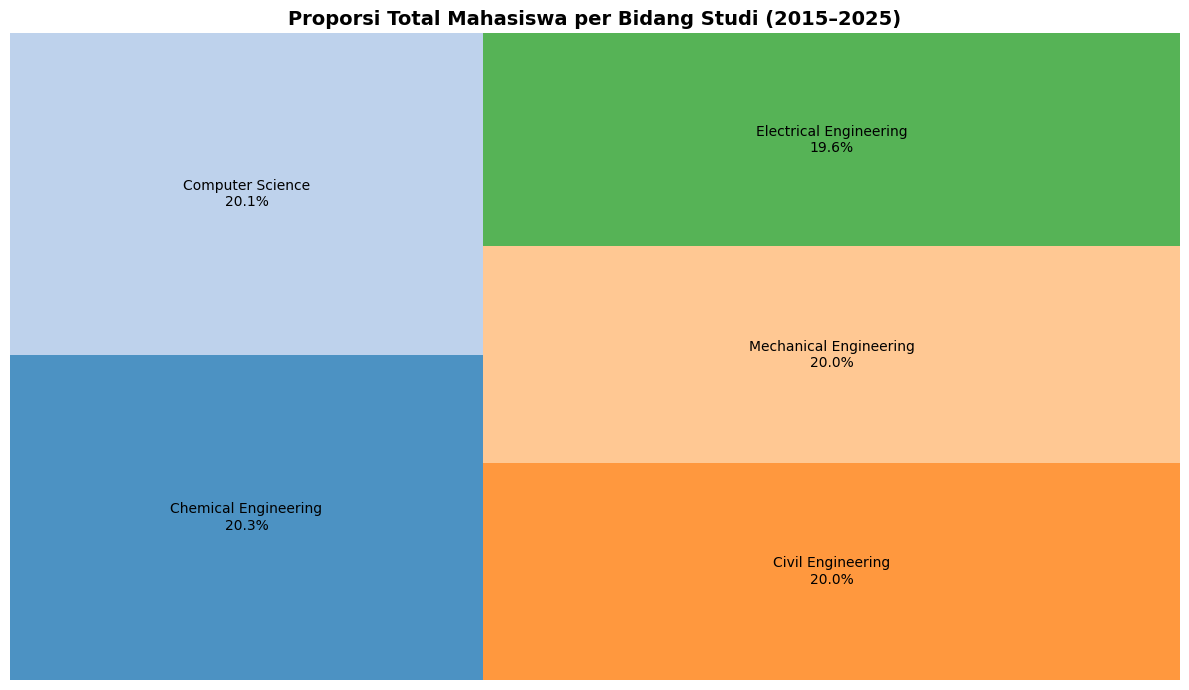

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # pip install squarify

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom bidang_studi ada
assert 'bidang_studi' in df.columns, "Kolom 'bidang_studi' tidak ditemukan!"

# -------------------------------
# 2️⃣ Hitung total mahasiswa per bidang studi
bidang_total = df['bidang_studi'].value_counts()
labels = [f"{i}\n{v/df.shape[0]*100:.1f}%" for i,v in zip(bidang_total.index, bidang_total.values)]
sizes = bidang_total.values

# -------------------------------
# 3️⃣ Plot treemap
plt.figure(figsize=(12,7))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.tab20.colors)
plt.title("Proporsi Total Mahasiswa per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


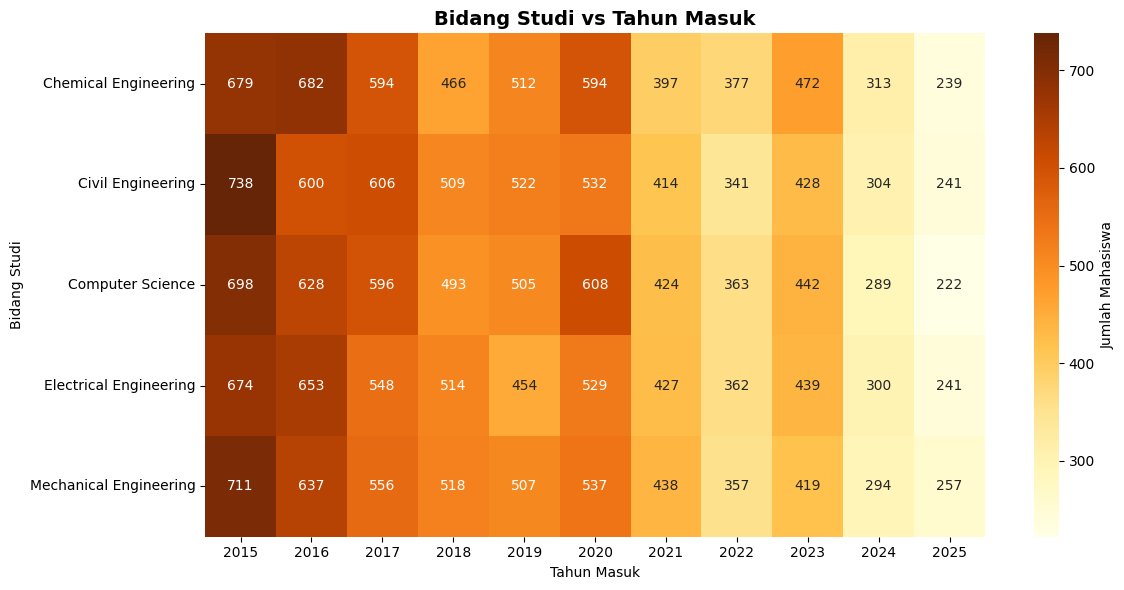

C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\645688580.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bidang_total.index, y=bidang_total.values, palette='tab20')


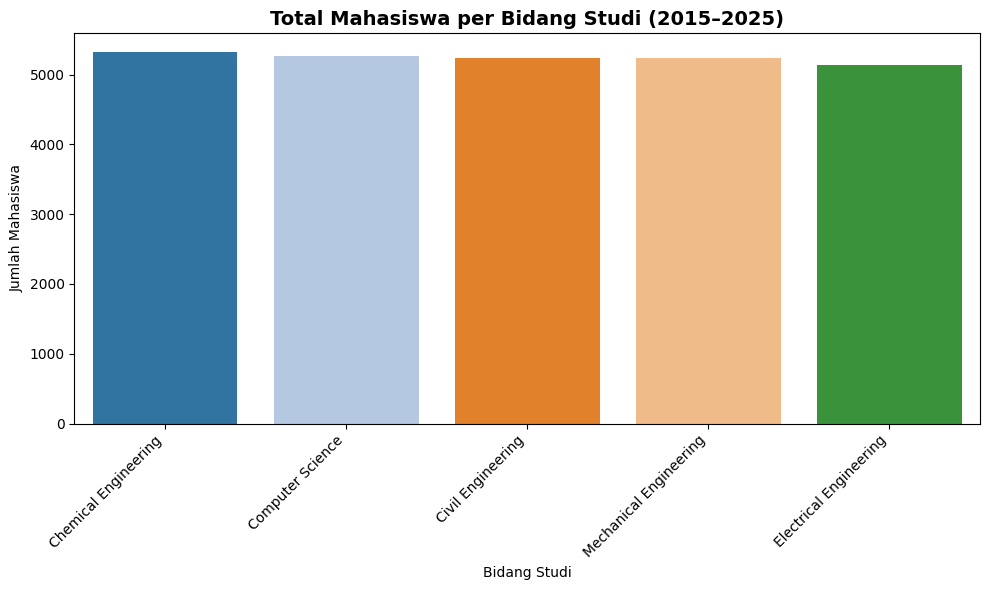

C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\645688580.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bidang_studi', y='biaya_masuk', data=df, palette='tab20')


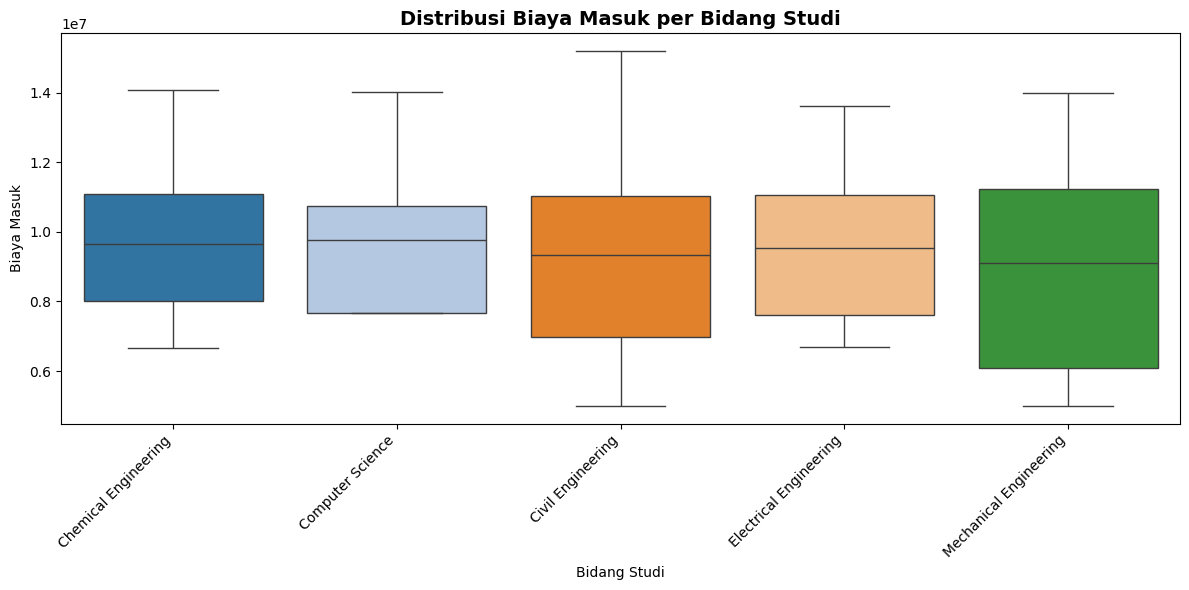

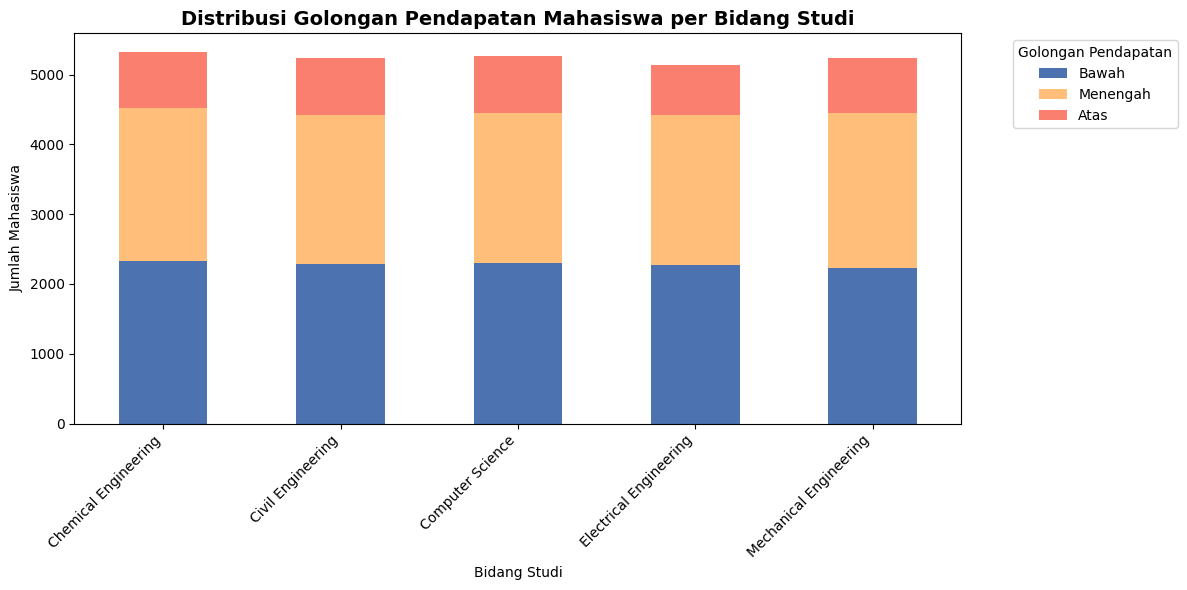

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Baca dataset
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# Pastikan kolom penting ada
for col in ['tahun_masuk','bidang_studi','biaya_masuk','kategori_pendapatan']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# -------------------------------
# 2️⃣ Korelasi: Bidang Studi vs Tahun Masuk
pivot_year = df.groupby(['bidang_studi','tahun_masuk']).size().unstack(fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(pivot_year, annot=True, fmt='d', cmap='YlOrBr', cbar_kws={'label':'Jumlah Mahasiswa'})
plt.title("Bidang Studi vs Tahun Masuk", fontsize=14, weight='bold')
plt.xlabel("Tahun Masuk")
plt.ylabel("Bidang Studi")
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Bidang Studi vs Jumlah Mahasiswa (Total)
bidang_total = df['bidang_studi'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=bidang_total.index, y=bidang_total.values, palette='tab20')
plt.title("Total Mahasiswa per Bidang Studi (2015–2025)", fontsize=14, weight='bold')
plt.xlabel("Bidang Studi")
plt.ylabel("Jumlah Mahasiswa")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------
# 4️⃣ Biaya Masuk vs Bidang Studi
plt.figure(figsize=(12,6))
sns.boxplot(x='bidang_studi', y='biaya_masuk', data=df, palette='tab20')
plt.title("Distribusi Biaya Masuk per Bidang Studi", fontsize=14, weight='bold')
plt.xlabel("Bidang Studi")
plt.ylabel("Biaya Masuk")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------
# 5️⃣ Bidang Studi vs Golongan Pendapatan Mahasiswa
pivot_golongan = df.groupby(['bidang_studi','kategori_pendapatan']).size().unstack(fill_value=0)
pivot_golongan = pivot_golongan[['Bawah','Menengah','Atas']]  # urut stack
pivot_golongan.plot(kind='bar', stacked=True, figsize=(12,6), color=['#4C72B0','#FFBE7A','#FA7F6F'])
plt.title("Distribusi Golongan Pendapatan Mahasiswa per Bidang Studi", fontsize=14, weight='bold')
plt.xlabel("Bidang Studi")
plt.ylabel("Jumlah Mahasiswa")
plt.legend(title="Golongan Pendapatan", bbox_to_anchor=(1.05,1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\LEPPY\AppData\Local\Temp\ipykernel_15816\3315930293.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,


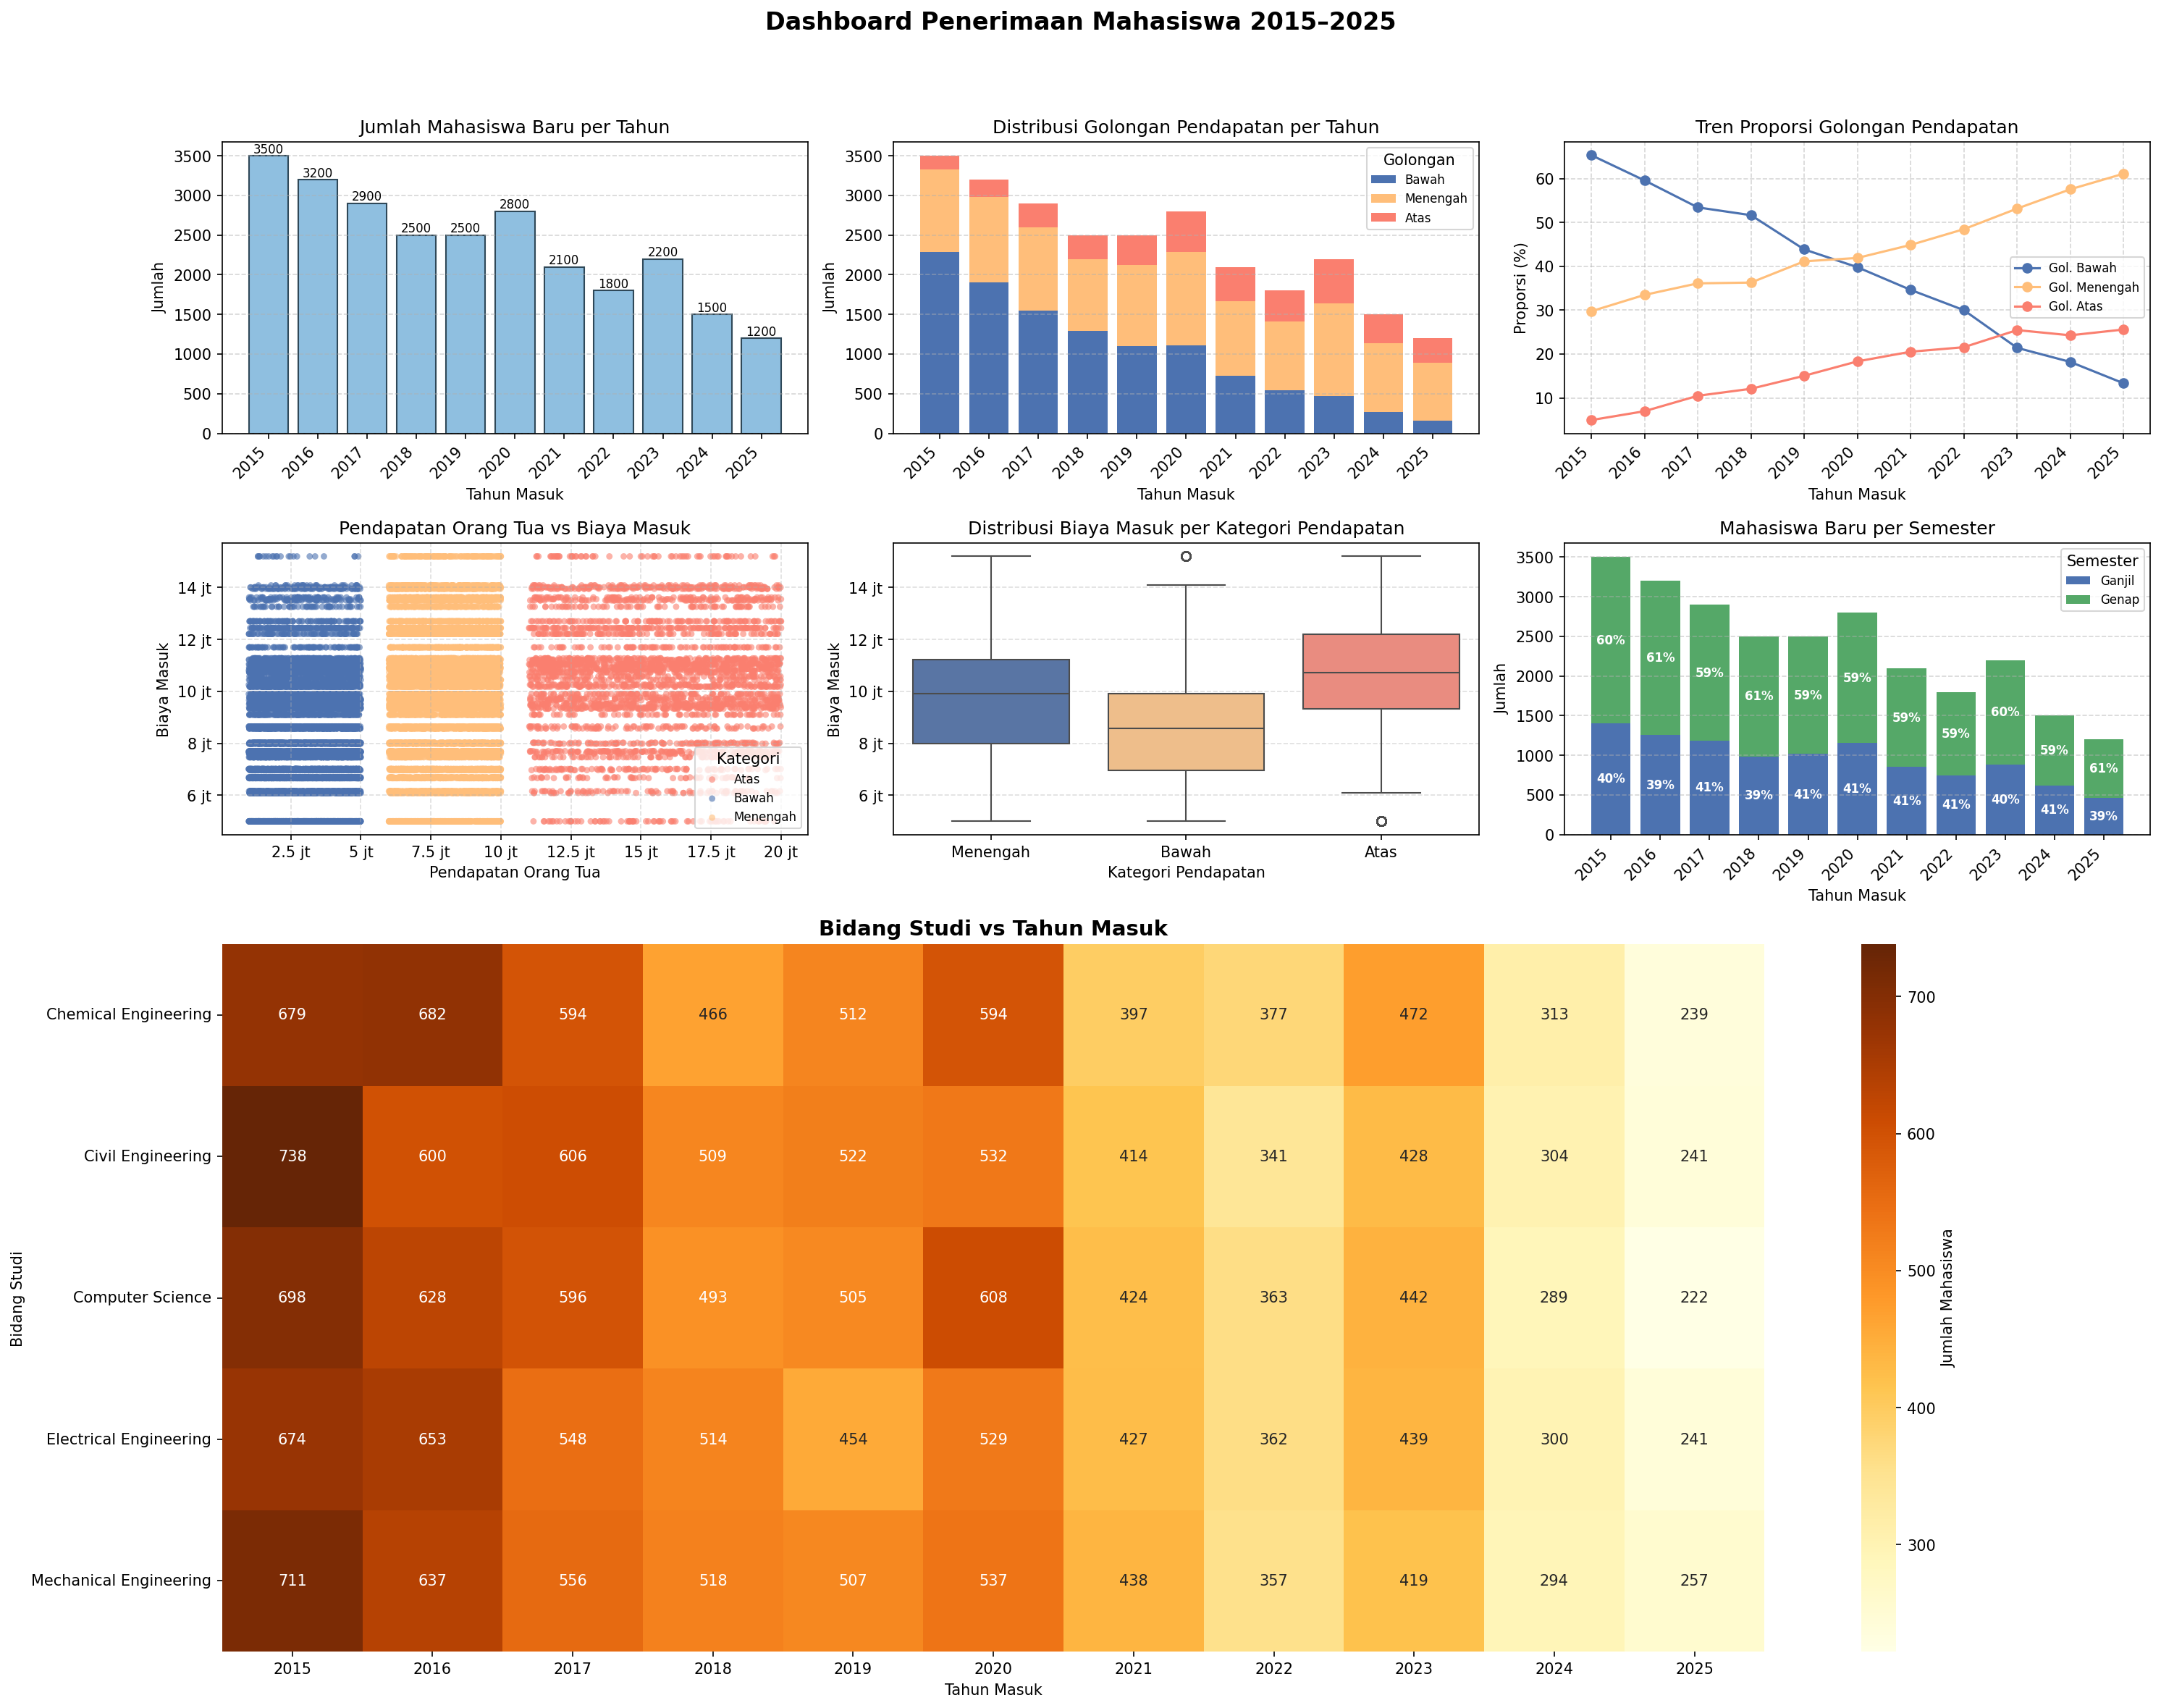

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

# ================== DATA ==================
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# cek kolom
for col in ['tahun_masuk','kategori_pendapatan','semester','pendapatan_ortu','biaya_masuk','bulan_masuk','bidang_studi']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# semester dari bulan_masuk (Agustus=Ganjil, Januari=Genap, lainnya biarkan)
def konversi_semester(row):
    b = str(row['bulan_masuk']).strip().lower()
    if b == 'agustus': return 'Ganjil'
    if b == 'januari': return 'Genap'
    return row['semester']
df['semester'] = df.apply(konversi_semester, axis=1)

# util format jutaan
def format_jutaan(x, pos=None):
    juta = x / 1_000_000
    return f"{int(juta)} jt" if float(juta).is_integer() else f"{juta:.1f} jt"

# pastikan tahun numeric & urut
df['tahun_masuk'] = pd.to_numeric(df['tahun_masuk'], errors='coerce')
tahun = sorted(df['tahun_masuk'].dropna().unique())

# turunan data
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()
pivot_income = df.groupby(['tahun_masuk','kategori_pendapatan']).size().unstack(fill_value=0).reindex(tahun).fillna(0)
prop_income  = pivot_income.div(pivot_income.sum(axis=1), axis=0)
pivot_sem    = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0).reindex(tahun).fillna(0)
pivot_studi  = df.groupby(['bidang_studi','tahun_masuk']).size().unstack(fill_value=0).reindex(columns=tahun).fillna(0)

# warna konsisten
colors_income = {'Bawah':'#4C72B0','Menengah':'#FFBE7A','Atas':'#FA7F6F'}
colors_sem    = {'Ganjil':'#4C72B0','Genap':'#55A868'}

# ================== DASHBOARD ==================
plt.rcParams.update({"axes.titlesize": 12, "axes.labelsize": 10})
fig = plt.figure(figsize=(20, 16), dpi=150)
gs = GridSpec(nrows=4, ncols=3, figure=fig, height_ratios=[1,1,1,1.05])

# (A) Bar jumlah per tahun
ax1 = fig.add_subplot(gs[0,0])
bars = ax1.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='#8FBFE0', edgecolor='#2F4858')
for b in bars:
    ax1.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}", ha='center', va='bottom', fontsize=8)
ax1.set_title("Jumlah Mahasiswa Baru per Tahun")
ax1.set_xlabel("Tahun Masuk"); ax1.set_ylabel("Jumlah")
ax1.set_xticks(tahun); ax1.set_xticklabels(tahun, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# (B) Stacked kategori pendapatan per tahun
ax2 = fig.add_subplot(gs[0,1])
bottom = np.zeros(len(pivot_income))
for cat in ['Bawah','Menengah','Atas']:
    if cat in pivot_income.columns:
        vals = pivot_income[cat].values
        ax2.bar(pivot_income.index, vals, bottom=bottom, label=cat, color=colors_income.get(cat,'gray'))
        bottom += vals
ax2.set_title("Distribusi Golongan Pendapatan per Tahun")
ax2.set_xlabel("Tahun Masuk"); ax2.set_ylabel("Jumlah")
ax2.set_xticks(tahun); ax2.set_xticklabels(tahun, rotation=45, ha='right')
ax2.legend(title="Golongan", fontsize=8)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# (C) Tren proporsi golongan pendapatan
ax3 = fig.add_subplot(gs[0,2])
for cat, col in colors_income.items():
    if cat in prop_income.columns:
        ax3.plot(prop_income.index, prop_income[cat]*100, marker='o', label=f"Gol. {cat}", color=col)
ax3.set_title("Tren Proporsi Golongan Pendapatan")
ax3.set_xlabel("Tahun Masuk"); ax3.set_ylabel("Proporsi (%)")
ax3.set_xticks(tahun); ax3.set_xticklabels(tahun, rotation=45, ha='right')
ax3.grid(True, linestyle='--', alpha=0.5); ax3.legend(fontsize=8, loc='best')

# (D) Scatter pendapatan vs biaya
ax4 = fig.add_subplot(gs[1,0])
for kat, sub in df.groupby('kategori_pendapatan'):
    ax4.scatter(sub['pendapatan_ortu'], sub['biaya_masuk'], s=18, alpha=0.6,
                label=kat, edgecolor='none', color=colors_income.get(kat,'gray'))
ax4.set_title("Pendapatan Orang Tua vs Biaya Masuk")
ax4.set_xlabel("Pendapatan Orang Tua"); ax4.set_ylabel("Biaya Masuk")
ax4.xaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax4.yaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax4.grid(True, linestyle='--', alpha=0.4); ax4.legend(title="Kategori", fontsize=8)

# (E) Boxplot biaya per kategori pendapatan
ax5 = fig.add_subplot(gs[1,1])
sns.boxplot(x='kategori_pendapatan', y='biaya_masuk', data=df,
            palette=[colors_income.get('Bawah','#4C72B0'),
                     colors_income.get('Menengah','#FFBE7A'),
                     colors_income.get('Atas','#FA7F6F')], ax=ax5)
ax5.set_title("Distribusi Biaya Masuk per Kategori Pendapatan")
ax5.set_xlabel("Kategori Pendapatan"); ax5.set_ylabel("Biaya Masuk")
ax5.yaxis.set_major_formatter(FuncFormatter(format_jutaan))
ax5.grid(axis='y', linestyle='--', alpha=0.4)

# (F) Stacked semester + persen di dalam batang
ax6 = fig.add_subplot(gs[1,2])
bottom = np.zeros(len(pivot_sem))
for sem in ['Ganjil','Genap']:
    if sem in pivot_sem.columns:
        vals = pivot_sem[sem].values
        ax6.bar(pivot_sem.index, vals, bottom=bottom, label=sem, color=colors_sem.get(sem,'gray'))
        for i, x in enumerate(pivot_sem.index):
            h = vals[i]; tot = pivot_sem.loc[x].sum()
            if h>0 and tot>0:
                ax6.text(x, bottom[i] + h/2, f"{(h/tot*100):.0f}%", ha='center', va='center', color='white', fontsize=8, weight='bold')
        bottom += vals
ax6.set_title("Mahasiswa Baru per Semester")
ax6.set_xlabel("Tahun Masuk"); ax6.set_ylabel("Jumlah")
ax6.set_xticks(tahun); ax6.set_xticklabels(tahun, rotation=45, ha='right')
ax6.legend(title="Semester", fontsize=8); ax6.grid(axis='y', linestyle='--', alpha=0.5)

# (G) Heatmap bidang studi vs tahun
ax7 = fig.add_subplot(gs[2:4, :])  # span 2 baris dan 3 kolom
sns.heatmap(pivot_studi, annot=True, fmt='d', cmap='YlOrBr', cbar_kws={'label':'Jumlah Mahasiswa'}, ax=ax7)
ax7.set_title("Bidang Studi vs Tahun Masuk", fontsize=14, weight='bold')
ax7.set_xlabel("Tahun Masuk")
ax7.set_ylabel("Bidang Studi")

# judul dashboard
fig.suptitle("Dashboard Penerimaan Mahasiswa 2015–2025", fontsize=16, weight='bold', y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


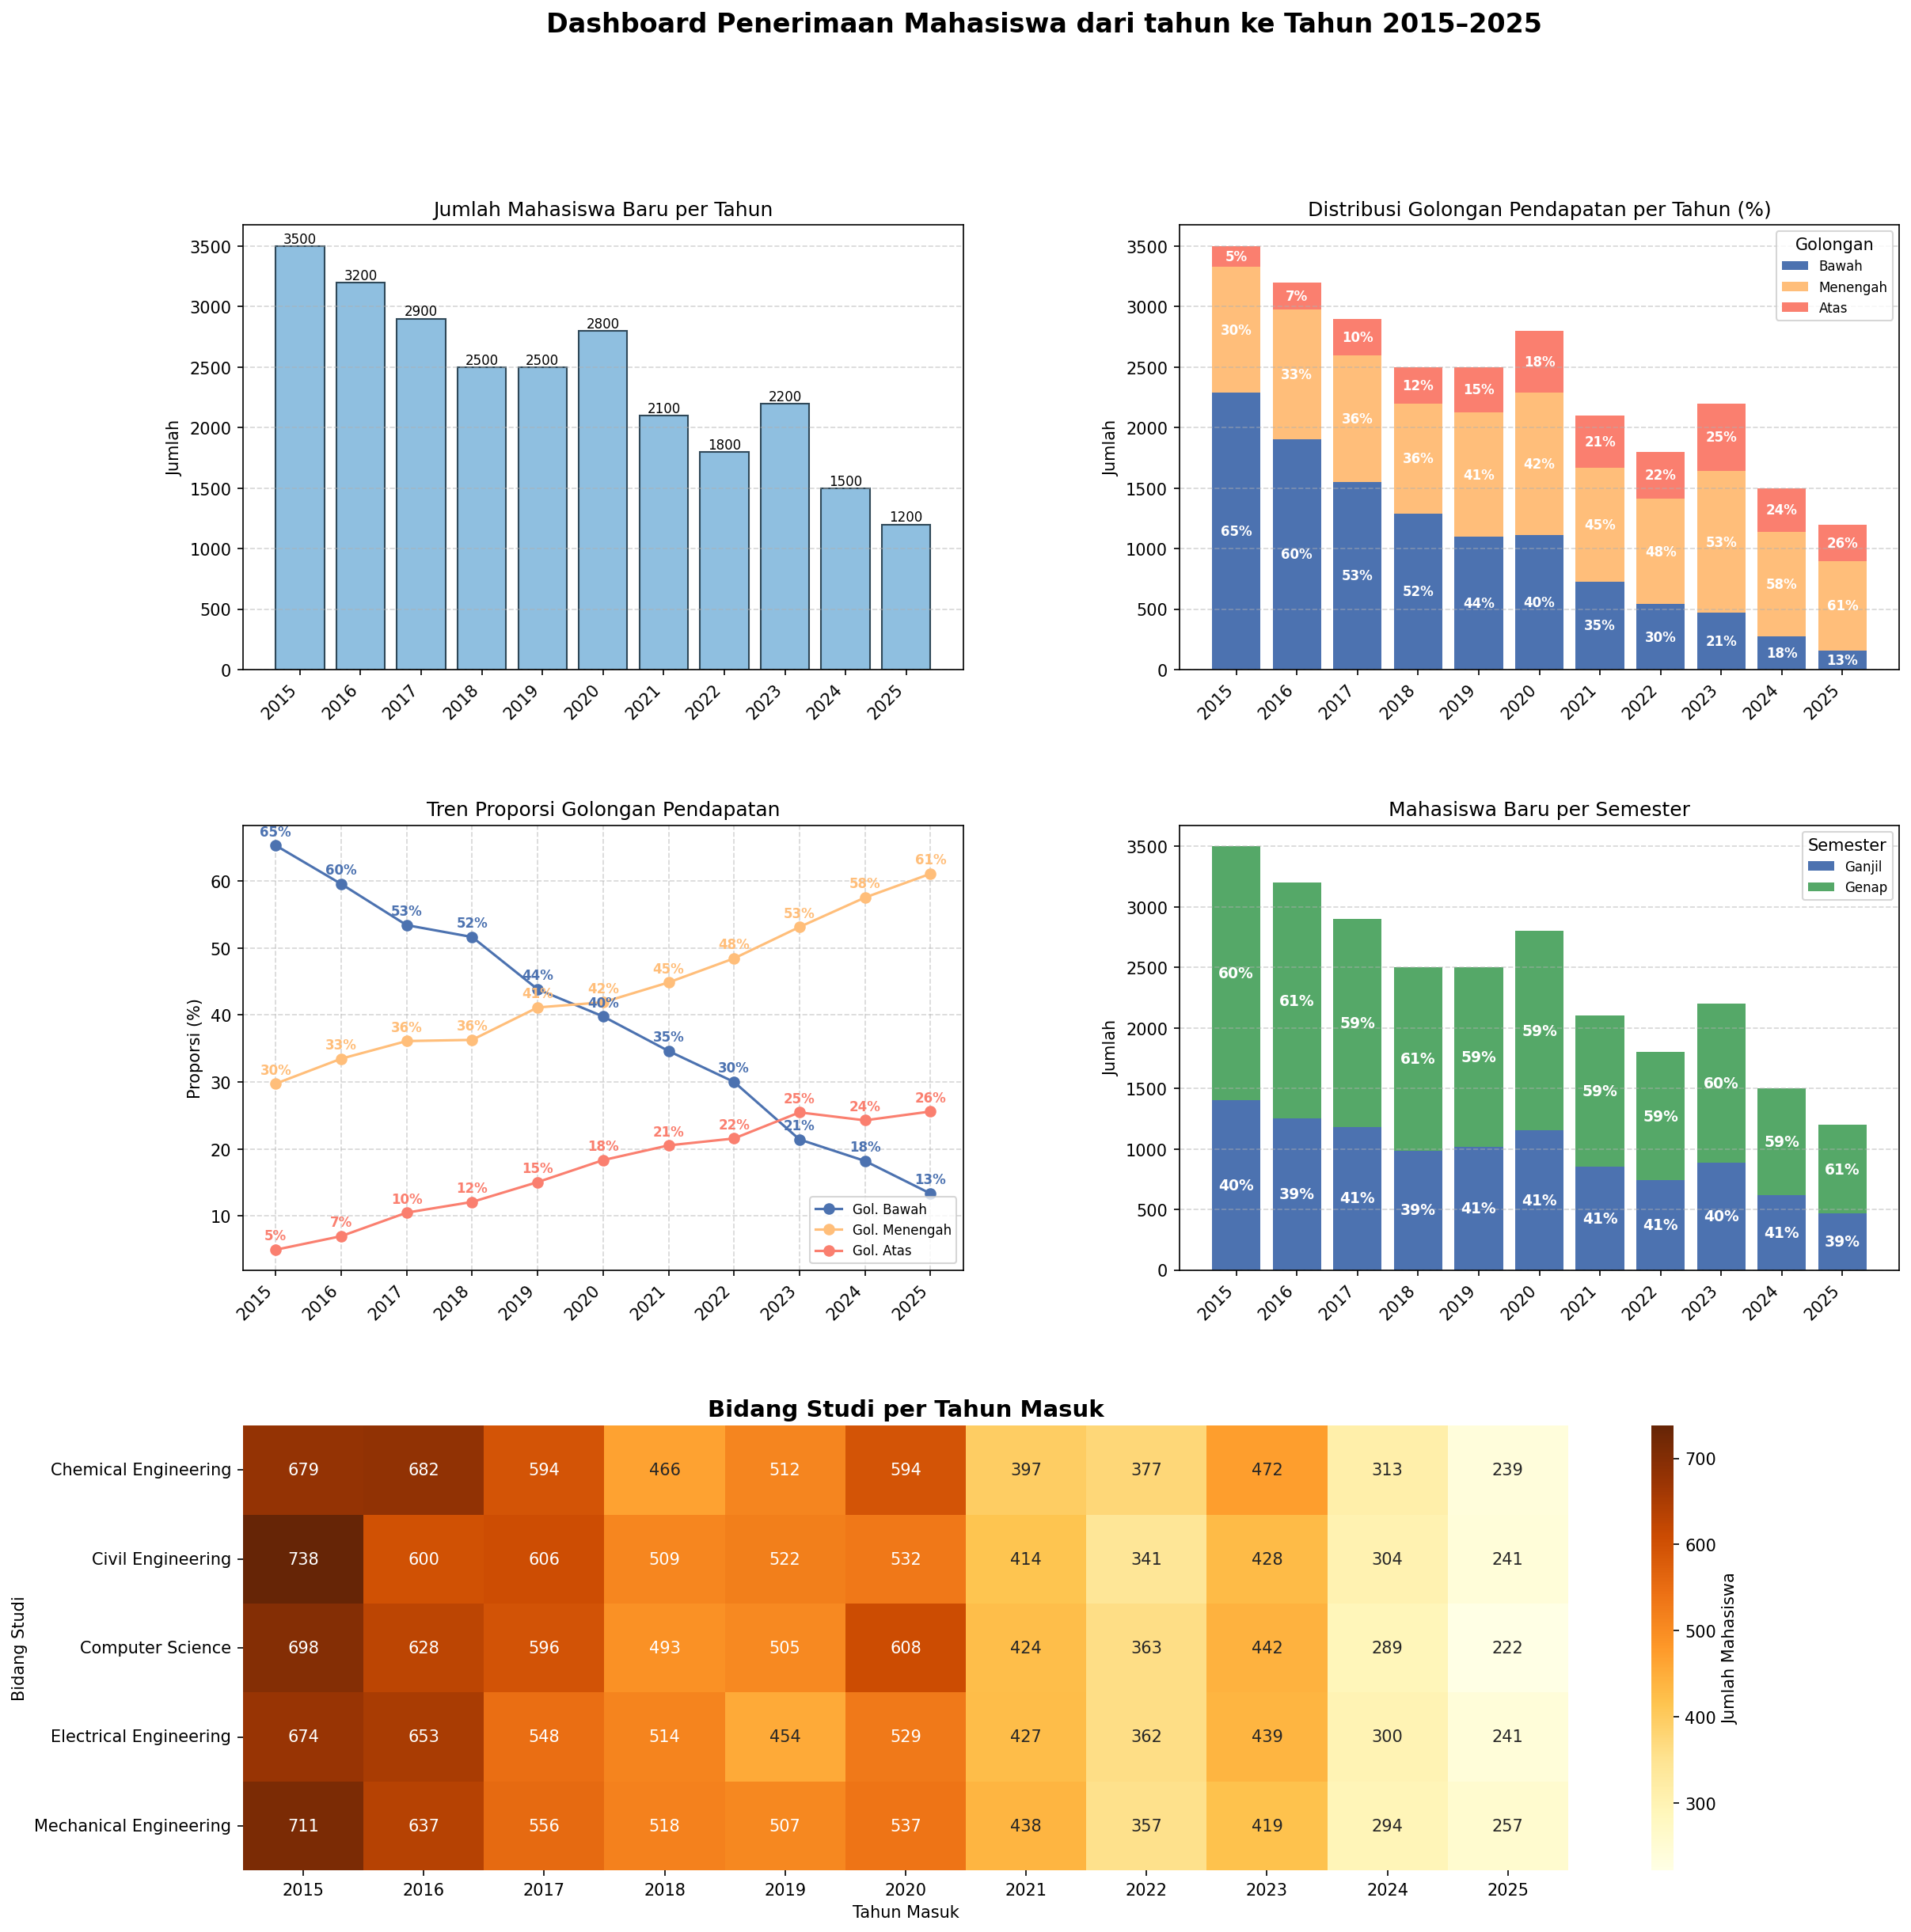

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

# ================== DATA ==================
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# cek kolom
for col in ['tahun_masuk','kategori_pendapatan','semester','bulan_masuk','bidang_studi']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# semester dari bulan_masuk
def konversi_semester(row):
    b = str(row['bulan_masuk']).strip().lower()
    if b == 'agustus': return 'Ganjil'
    if b == 'januari': return 'Genap'
    return row['semester']
df['semester'] = df.apply(konversi_semester, axis=1)

# pastikan tahun numeric & urut
df['tahun_masuk'] = pd.to_numeric(df['tahun_masuk'], errors='coerce')
tahun = sorted(df['tahun_masuk'].dropna().unique())

# turunan data
jumlah_per_tahun = df['tahun_masuk'].value_counts().sort_index()
pivot_income = df.groupby(['tahun_masuk','kategori_pendapatan']).size().unstack(fill_value=0).reindex(tahun).fillna(0)
prop_income  = pivot_income.div(pivot_income.sum(axis=1), axis=0)
pivot_sem    = df.groupby(['tahun_masuk','semester']).size().unstack(fill_value=0).reindex(tahun).fillna(0)
pivot_studi  = df.groupby(['bidang_studi','tahun_masuk']).size().unstack(fill_value=0).reindex(columns=tahun).fillna(0)

# warna konsisten
colors_income = {'Bawah':'#4C72B0','Menengah':'#FFBE7A','Atas':'#FA7F6F'}
colors_sem    = {'Ganjil':'#4C72B0','Genap':'#55A868'}

# ================== DASHBOARD PERSEGI ==================
plt.rcParams.update({"axes.titlesize": 12, "axes.labelsize": 10})
fig = plt.figure(figsize=(18, 18), dpi=150)
gs = GridSpec(nrows=3, ncols=2, figure=fig, hspace=0.35, wspace=0.3)  # 3x2 grid

# (A) Jumlah mahasiswa per tahun
ax1 = fig.add_subplot(gs[0,0])
bars = ax1.bar(jumlah_per_tahun.index, jumlah_per_tahun.values, color='#8FBFE0', edgecolor='#2F4858')
for b in bars:
    ax1.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}", ha='center', va='bottom', fontsize=8)
ax1.set_title("Jumlah Mahasiswa Baru per Tahun")
ax1.set_xticks(tahun); ax1.set_xticklabels(tahun, rotation=45, ha='right')
ax1.set_ylabel("Jumlah"); ax1.grid(axis='y', linestyle='--', alpha=0.5)

# (B) Distribusi Golongan Pendapatan per Tahun dengan persentase
ax2 = fig.add_subplot(gs[0,1])
bottom = np.zeros(len(pivot_income))
for cat in ['Bawah','Menengah','Atas']:
    if cat in pivot_income.columns:
        vals = pivot_income[cat].values
        bars = ax2.bar(pivot_income.index, vals, bottom=bottom, label=cat, color=colors_income.get(cat,'gray'))
        # tambahkan nilai persentase di tengah segmen
        for i, b in enumerate(bars):
            total_tahun = pivot_income.loc[pivot_income.index[i]].sum()
            if total_tahun > 0 and vals[i] > 0:
                persentase = vals[i] / total_tahun * 100
                ax2.text(b.get_x() + b.get_width()/2, bottom[i] + vals[i]/2, 
                         f"{persentase:.0f}%", ha='center', va='center', fontsize=8, color='white', weight='bold')
        bottom += vals
ax2.set_title("Distribusi Golongan Pendapatan per Tahun (%)")
ax2.set_xticks(tahun); ax2.set_xticklabels(tahun, rotation=45, ha='right')
ax2.set_ylabel("Jumlah"); ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.legend(title="Golongan", fontsize=8)


# (C) Tren Proporsi Golongan Pendapatan dengan persentase di tiap dot
ax3 = fig.add_subplot(gs[1,0])
for cat, col in colors_income.items():
    if cat in prop_income.columns:
        ax3.plot(prop_income.index, prop_income[cat]*100, marker='o', label=f"Gol. {cat}", color=col)
        # tambahkan nilai persentase di atas setiap dot
        for x, y in zip(prop_income.index, prop_income[cat]*100):
            ax3.text(x, y + 1, f"{y:.0f}%", ha='center', va='bottom', fontsize=8, weight='bold', color=col)
ax3.set_title("Tren Proporsi Golongan Pendapatan")
ax3.set_xticks(tahun); ax3.set_xticklabels(tahun, rotation=45, ha='right')
ax3.set_ylabel("Proporsi (%)"); ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend(fontsize=8, loc='best')


# (D) Mahasiswa Baru per Semester
ax4 = fig.add_subplot(gs[1,1])
bottom = np.zeros(len(pivot_sem))
for sem in ['Ganjil','Genap']:
    if sem in pivot_sem.columns:
        vals = pivot_sem[sem].values
        ax4.bar(pivot_sem.index, vals, bottom=bottom, label=sem, color=colors_sem.get(sem,'gray'))
        for i, x in enumerate(pivot_sem.index):
            h = vals[i]; tot = pivot_sem.loc[x].sum()
            if h>0 and tot>0:
                ax4.text(x, bottom[i]+h/2, f"{(h/tot*100):.0f}%", ha='center', va='center', color='white', fontsize=9, weight='bold')
        bottom += vals
ax4.set_title("Mahasiswa Baru per Semester")
ax4.set_xticks(tahun); ax4.set_xticklabels(tahun, rotation=45, ha='right')
ax4.set_ylabel("Jumlah"); ax4.grid(axis='y', linestyle='--', alpha=0.5)
ax4.legend(title="Semester", fontsize=8)

# (E) Heatmap Bidang Studi vs Tahun Masuk (span 2 kolom bawah)
ax5 = fig.add_subplot(gs[2, :])
sns.heatmap(pivot_studi, annot=True, fmt='d', cmap='YlOrBr', cbar_kws={'label':'Jumlah Mahasiswa'}, ax=ax5)
ax5.set_title("Bidang Studi per Tahun Masuk", fontsize=14, weight='bold')
ax5.set_xlabel("Tahun Masuk"); ax5.set_ylabel("Bidang Studi")

# judul dashboard
fig.suptitle("Dashboard Penerimaan Mahasiswa dari tahun ke Tahun 2015–2025", fontsize=16, weight='bold', y=0.98)
plt.savefig("dashboard_peneriman.png", dpi=300)
plt.show()


📈 Korelasi Pearson antara pendapatan orang tua dan biaya masuk: 0.276 (p-value=0.000e+00)


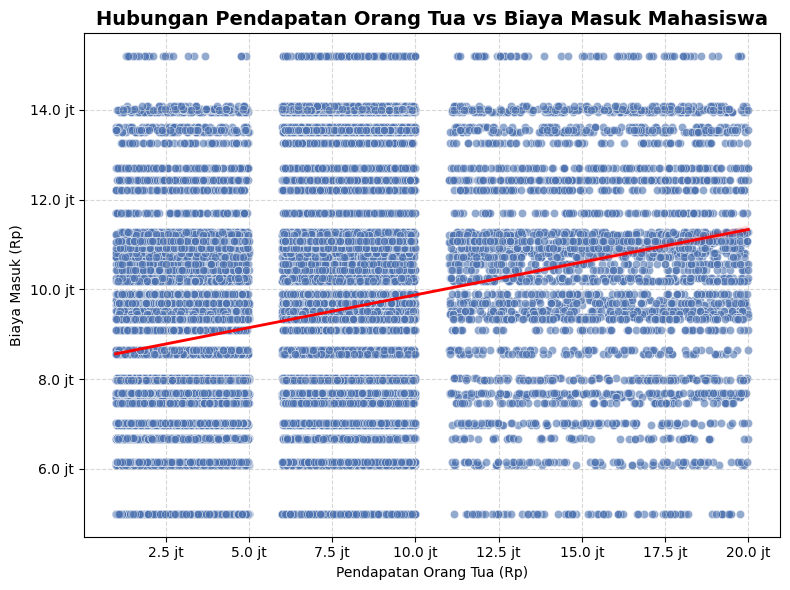

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ================== DATA ==================
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# pastikan kolom penting ada
for col in ['pendapatan_ortu', 'biaya_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# hilangkan nilai kosong
df_clean = df[['pendapatan_ortu','biaya_masuk']].dropna()

# hitung korelasi Pearson
corr, pval = pearsonr(df_clean['pendapatan_ortu'], df_clean['biaya_masuk'])
print(f"📈 Korelasi Pearson antara pendapatan orang tua dan biaya masuk: {corr:.3f} (p-value={pval:.3e})")

# ================== VISUALISASI ==================
plt.figure(figsize=(8,6))
sns.scatterplot(x='pendapatan_ortu', y='biaya_masuk', data=df_clean, alpha=0.6, color='#4C72B0')
sns.regplot(x='pendapatan_ortu', y='biaya_masuk', data=df_clean, scatter=False, color='red', line_kws={'lw':2})

plt.title("Hubungan Pendapatan Orang Tua vs Biaya Masuk Mahasiswa", fontsize=14, weight='bold')
plt.xlabel("Pendapatan Orang Tua (Rp)")
plt.ylabel("Biaya Masuk (Rp)")
plt.grid(True, linestyle='--', alpha=0.5)

# format angka jutaan agar lebih readable
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f} jt"))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} jt"))

plt.tight_layout()
plt.show()


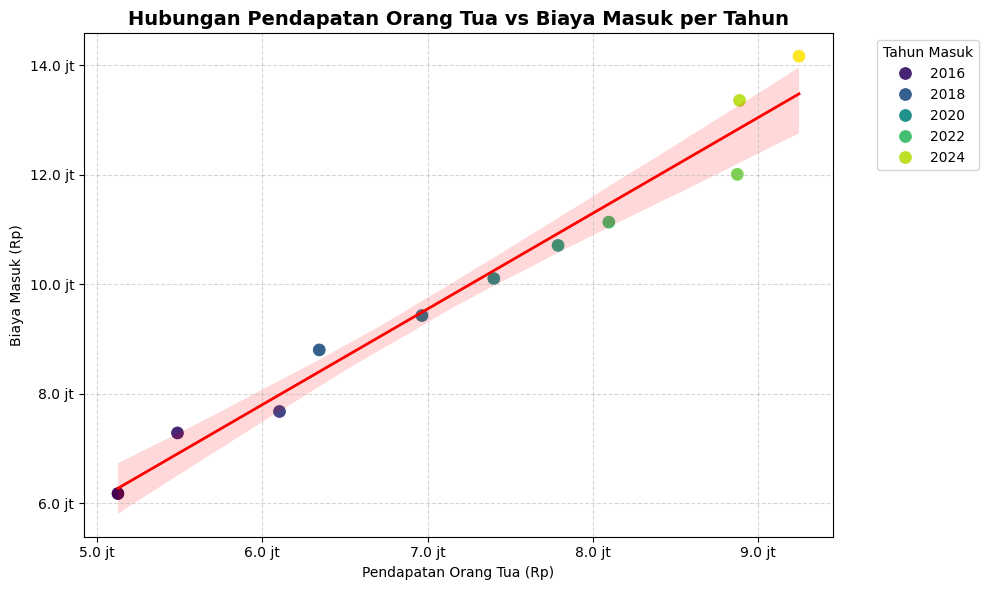

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================== DATA ==================
df = pd.read_csv("student_data_final_adjusted_processed_indo_rupiah_final_reduced_v5.csv")

# pastikan kolom penting ada
for col in ['pendapatan_ortu', 'biaya_masuk', 'tahun_masuk']:
    assert col in df.columns, f"Kolom '{col}' tidak ditemukan!"

# hilangkan nilai kosong
df_clean = df[['pendapatan_ortu','biaya_masuk','tahun_masuk']].dropna()

# hitung rata-rata biaya masuk per tahun
df_grouped = df_clean.groupby('tahun_masuk').agg({
    'pendapatan_ortu':'mean',
    'biaya_masuk':'mean'
}).reset_index()

# ================== VISUALISASI ==================
plt.figure(figsize=(10,6))
sns.scatterplot(x='pendapatan_ortu', y='biaya_masuk', hue='tahun_masuk',
                palette='viridis', s=100, data=df_grouped)

# garis tren global
sns.regplot(x='pendapatan_ortu', y='biaya_masuk', data=df_grouped, scatter=False, color='red', line_kws={'lw':2})

plt.title("Hubungan Pendapatan Orang Tua vs Biaya Masuk per Tahun", fontsize=14, weight='bold')
plt.xlabel("Pendapatan Orang Tua (Rp)")
plt.ylabel("Biaya Masuk (Rp)")
plt.grid(True, linestyle='--', alpha=0.5)

# format sumbu jutaan
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f} jt"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} jt"))

plt.legend(title='Tahun Masuk', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()
